Collected 4761 windows (200 ms each) across 8 sessions.


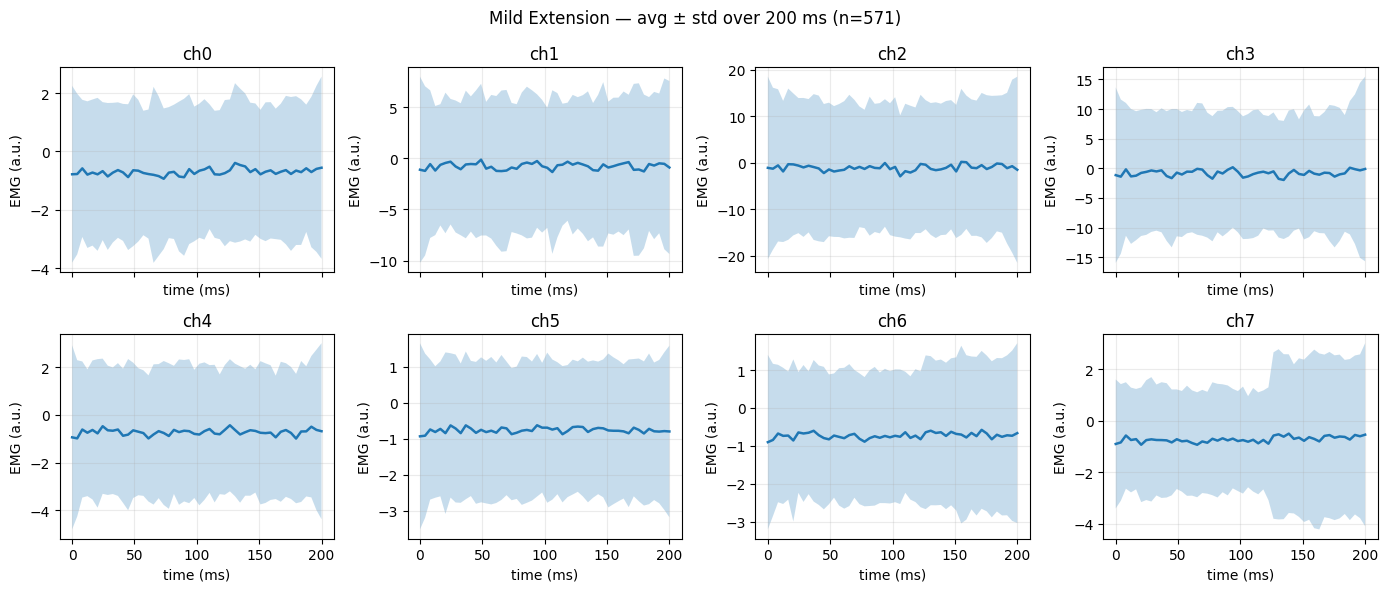

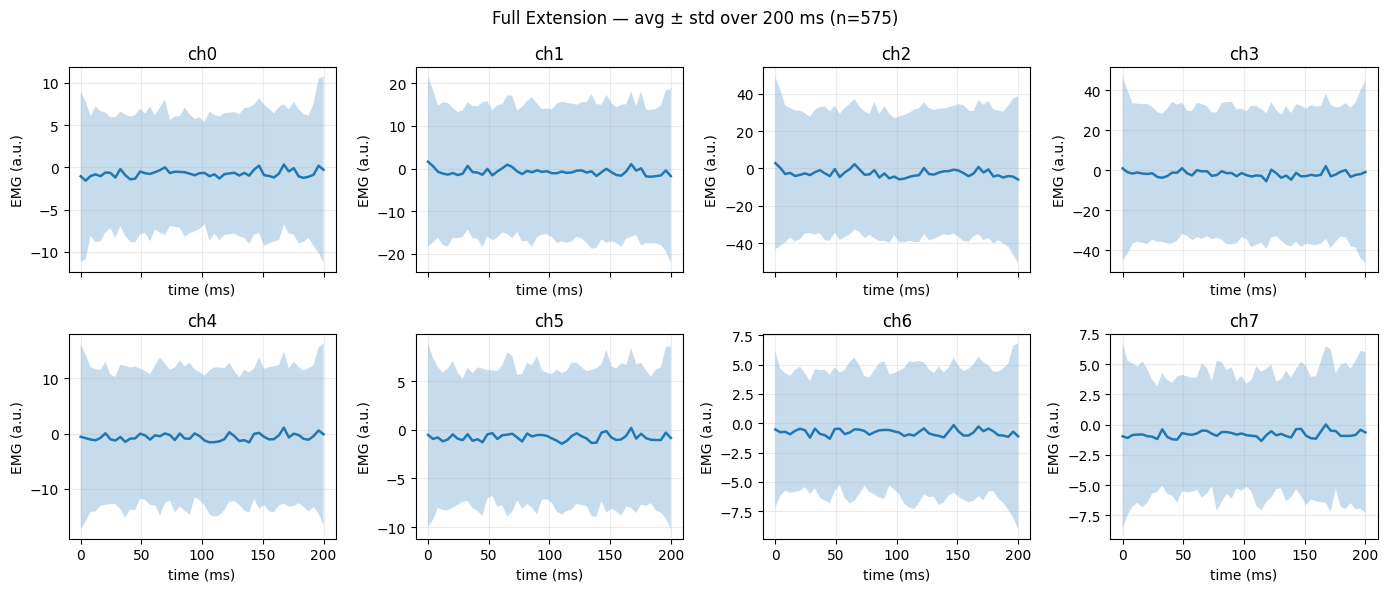

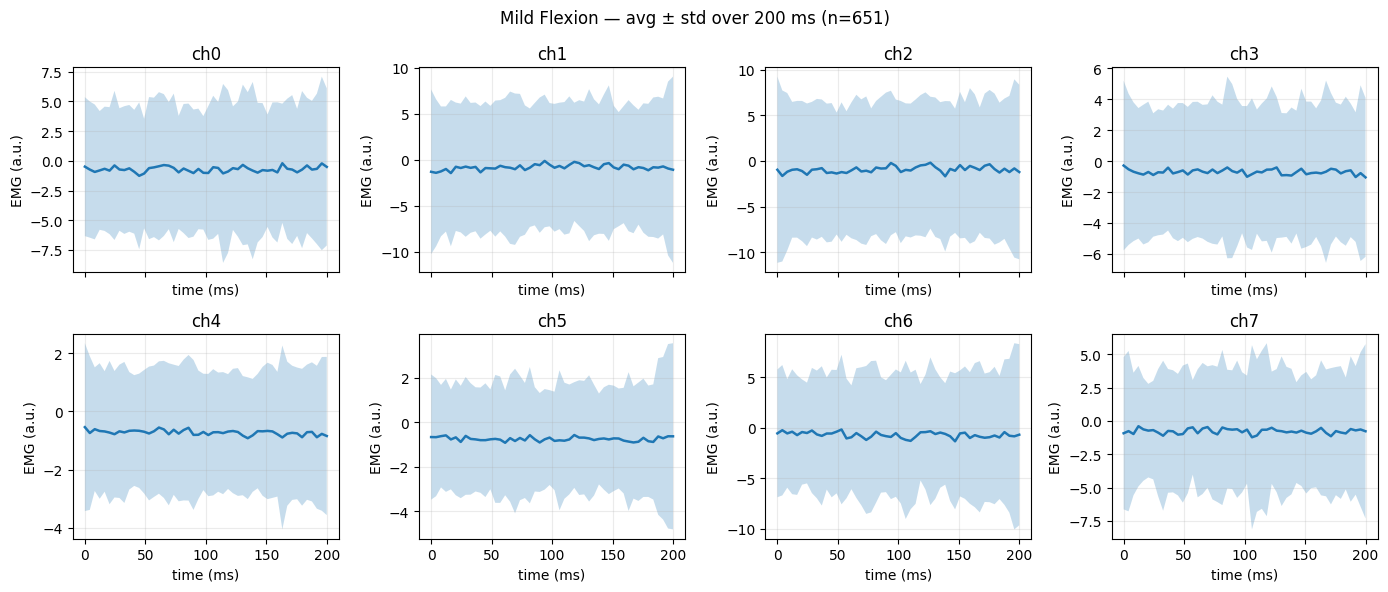

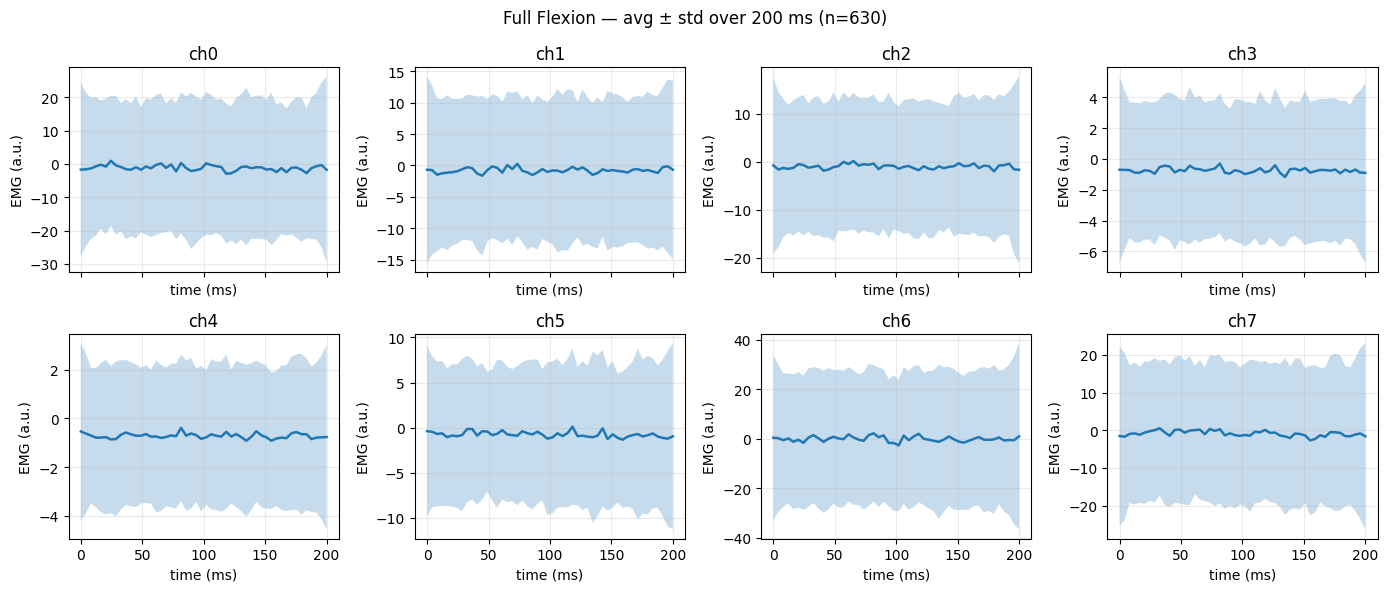

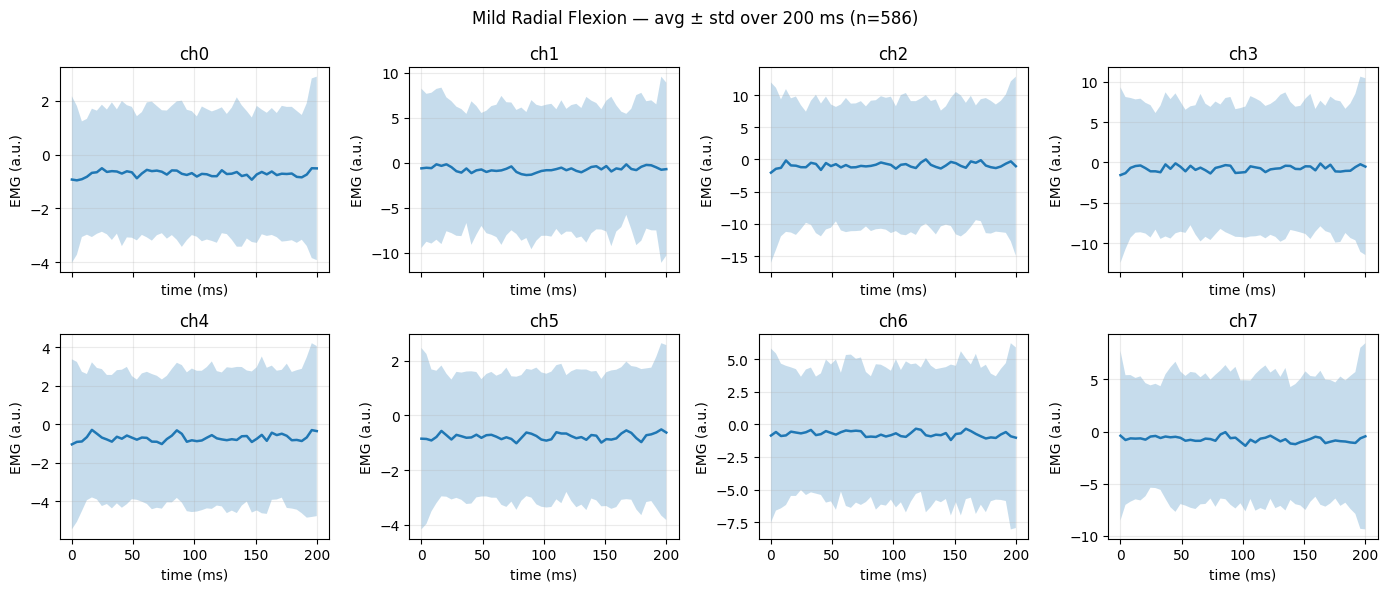

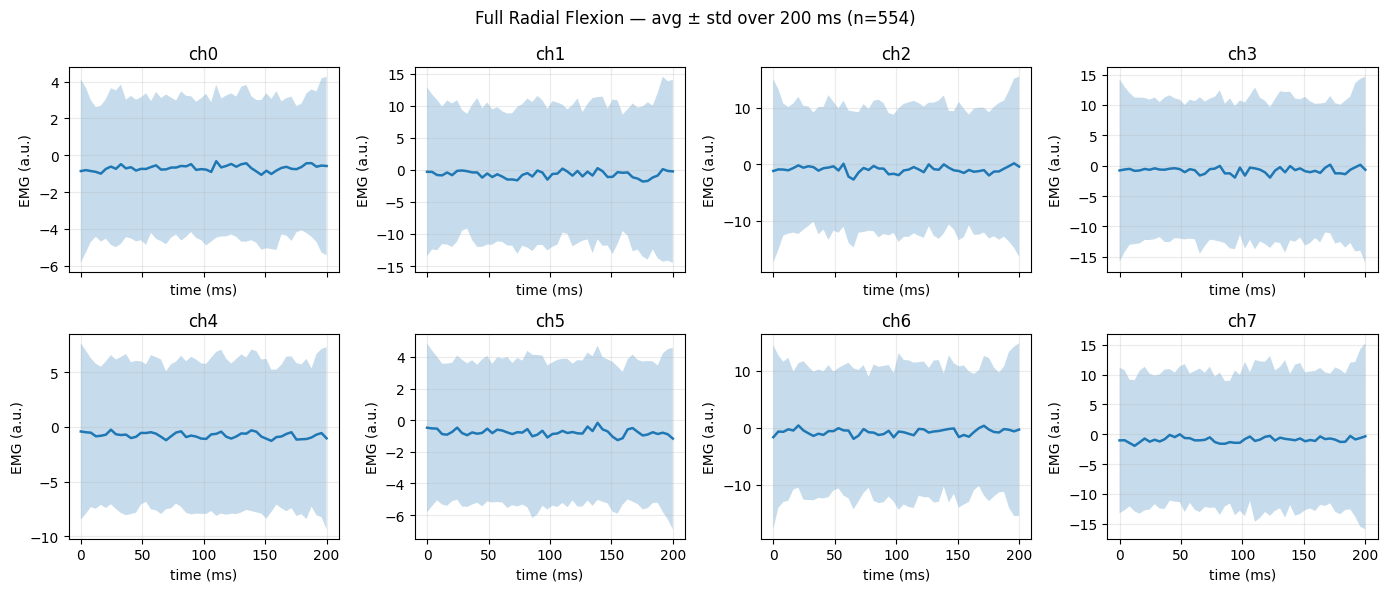

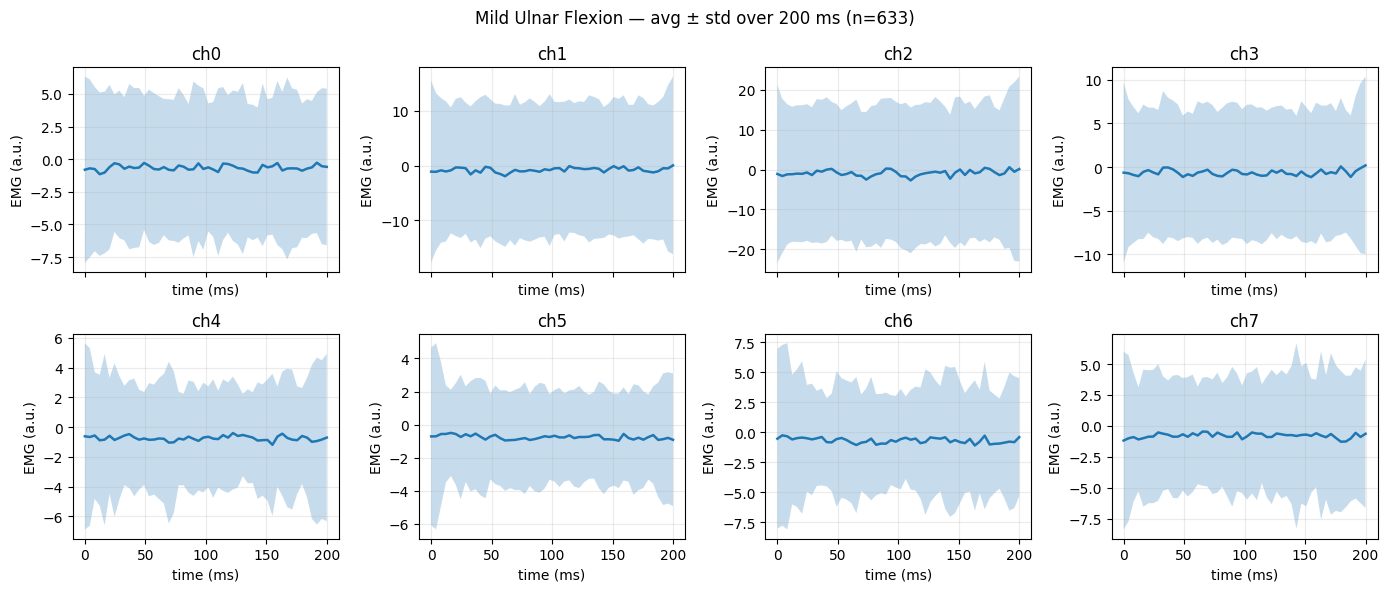

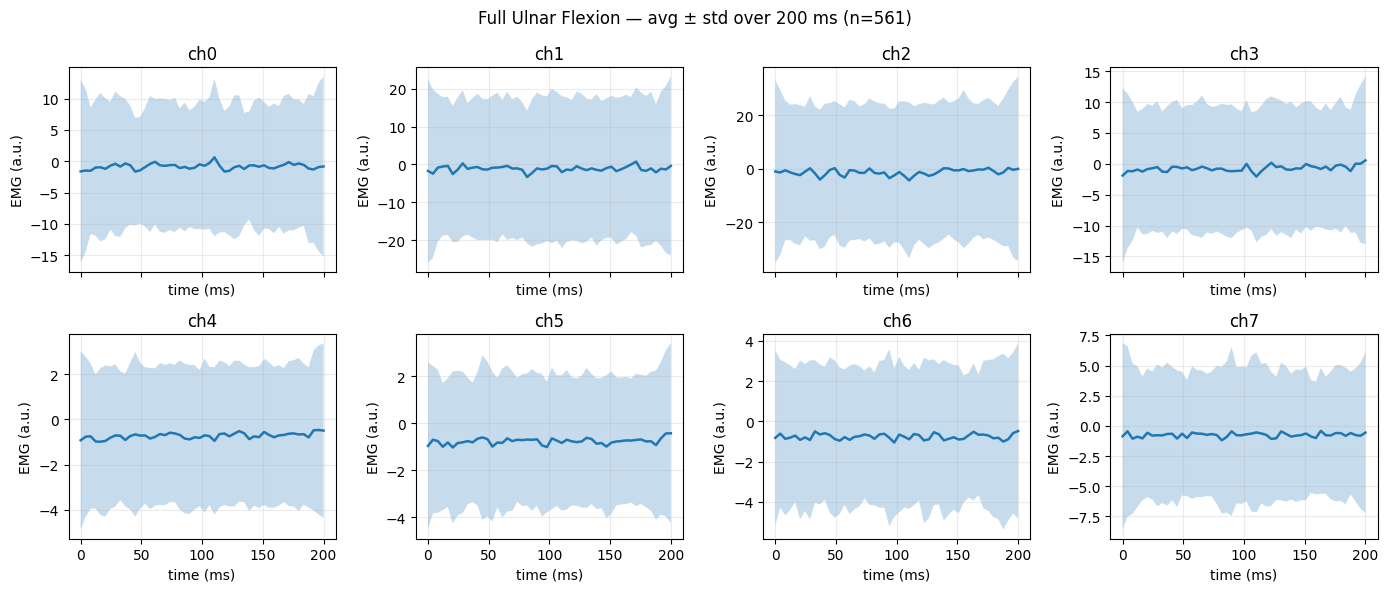

In [1]:
# JUPYTER CELL — Mean ± Std per class (200 ms windows) across ALL participants & sessions

import os, csv, glob
import numpy as np
import matplotlib.pyplot as plt

SESSIONS_ROOT = "emg_sessions"
INCLUDE_REST  = False            # set True to include label 0 in the plots
WINDOW_MS     = 200              # window length (ms)
GRID_POINTS   = 50               # resample points per window

LABELS = {
    0: "rest",
    1: "mild_extension",
    2: "full_extension",
    3: "mild_flexion",
    4: "full_flexion",
    5: "mild_radial_flexion",
    6: "full_radial_flexion",
    7: "mild_ulnar_flexion",
    8: "full_ulnar_flexion",
}

# ---------- Robust CSV ----------
def load_csv_table(path, delim=';'):
    for enc in ("utf-8", "cp1252", "latin-1"):
        try:
            with open(path, "r", newline="", encoding=enc, errors="strict") as fp:
                r = csv.reader(fp, delimiter=delim)
                header = next(r, None)
                rows = [row for row in r]
            return header, rows
        except UnicodeDecodeError:
            continue
    with open(path, "r", newline="", encoding="utf-8", errors="replace") as fp:
        r = csv.reader(fp, delimiter=delim)
        header = next(r, None)
        rows = [row for row in r]
    return header, rows

# ---------- Discover all sessions (every participant) ----------
def all_session_dirs(root=SESSIONS_ROOT):
    if not os.path.isdir(root):
        return []
    sessions = []
    for participant in sorted(os.listdir(root)):
        pdir = os.path.join(root, participant)
        if not os.path.isdir(pdir): 
            continue
        for sess in sorted(os.listdir(pdir)):
            sdir = os.path.join(pdir, sess)
            if os.path.isdir(sdir) and \
               os.path.isfile(os.path.join(sdir, "samples.csv")) and \
               os.path.isfile(os.path.join(sdir, "events.csv")):
                sessions.append(sdir)
    return sessions

# ---------- Load samples ----------
def load_samples(samples_rows):
    ts_us, lab = [], []
    chs = [[] for _ in range(8)]
    for row in samples_rows:
        try:
            ts_us.append(int(row[0]))
            lab.append(int(row[3]))            # active_label_id
            for k in range(8):
                chs[k].append(float(row[6+k]))
        except Exception:
            pass
    ts_us = np.asarray(ts_us, dtype=np.int64)
    order = np.argsort(ts_us)
    ts_us = ts_us[order]
    lab   = np.asarray(lab, dtype=np.int16)[order]
    ch    = np.vstack([np.asarray(chs[k], dtype=np.float32) for k in range(8)])[:, order]  # 8×N
    return ts_us, lab, ch

# ---------- Build trials from labels; mark failed/noisy by events ----------
def derive_trials_from_labels(ts_us, lab):
    """Contiguous runs with label>0 → trials with status 'ok'."""
    trials = []
    if lab.size == 0:
        return trials
    in_run = False
    cur_label = 0
    start_us = None
    for i in range(lab.size):
        if not in_run and lab[i] > 0:
            in_run = True
            cur_label = int(lab[i])
            start_us = int(ts_us[i])
        elif in_run:
            if lab[i] != cur_label or i == lab.size-1:
                end_idx = i if lab[i] != cur_label else i
                end_us = int(ts_us[end_idx])
                if end_us > start_us:
                    trials.append({"label_id": cur_label, "start_us": start_us, "end_us": end_us, "status": "ok"})
                in_run = False
                cur_label = 0
                start_us = None
    return trials

def apply_fail_noisy_from_events(trials, events_rows):
    """Mark most recent completed trial before each FAILED/NOISY event."""
    evs = []
    for row in events_rows:
        try:
            evs.append((int(row[0]), row[2]))
        except Exception:
            pass
    evs.sort(key=lambda x: x[0])
    for ts, ev in evs:
        if ev in ("FAILED", "NOISY"):
            for i in range(len(trials)-1, -1, -1):
                if trials[i]["status"] == "ok" and trials[i]["end_us"] <= ts:
                    trials[i]["status"] = "failed" if ev == "FAILED" else "noisy"
                    break
    return trials

# ---------- Windowing & interpolation ----------
def windows_from_interval(ts_us, start_us, end_us, win_us):
    t0 = start_us
    while t0 + win_us <= end_us:
        t1 = t0 + win_us
        i0 = np.searchsorted(ts_us, t0, side="left")
        i1 = np.searchsorted(ts_us, t1, side="right")
        if i1 > i0:
            yield i0, i1, t0, t1
        t0 = t1

def resample_window(ts_us, ch_8xN, t0, t1, npts):
    """Interpolate each channel to uniform grid in [t0,t1]."""
    t = ts_us.astype(np.float64)
    m = (t >= t0) & (t <= t1)
    if m.sum() < 2:
        m = (t >= t0 - 1e5) & (t <= t1 + 1e5)
    t_sub = t[m]
    if t_sub.size < 2:
        t_sub = np.array([t0, t1], dtype=np.float64)
        y_sub = ch_8xN[:, :1].repeat(2, axis=1)
    else:
        y_sub = ch_8xN[:, m]
    grid = np.linspace(t0, t1, npts, dtype=np.float64)
    out = np.empty((8, npts), dtype=np.float32)
    for c in range(8):
        out[c] = np.interp(grid, t_sub, y_sub[c])
    return (grid - t0) / 1e6, out

# ---------- Aggregate windows across ALL sessions ----------
sess_dirs = all_session_dirs(SESSIONS_ROOT)
if not sess_dirs:
    raise RuntimeError(f"No sessions found under {SESSIONS_ROOT}/")

wanted_labels = range(0, 9) if INCLUDE_REST else range(1, 9)
class_windows = {k: [] for k in wanted_labels}
total_windows = 0

for sdir in sess_dirs:
    _, samples_rows = load_csv_table(os.path.join(sdir, "samples.csv"), delim=';')
    _, events_rows  = load_csv_table(os.path.join(sdir, "events.csv"),  delim=';')

    ts, lab, ch = load_samples(samples_rows)
    trials = derive_trials_from_labels(ts, lab)
    trials = apply_fail_noisy_from_events(trials, events_rows)

    for tr in trials:
        if tr["status"] != "ok": 
            continue
        if tr["label_id"] not in wanted_labels:
            continue
        for i0, i1, t0, t1 in windows_from_interval(ts, tr["start_us"], tr["end_us"], win_us=int(WINDOW_MS*1000)):
            _, W = resample_window(ts[i0:i1], ch[:, i0:i1], t0, t1, GRID_POINTS)  # 8×T
            class_windows[tr["label_id"]].append(W)
            total_windows += 1

print(f"Collected {total_windows} windows ({WINDOW_MS} ms each) across {len(sess_dirs)} sessions.")

# ---------- Plot: mean ± std per class ----------
time_axis_ms = np.linspace(0, WINDOW_MS, GRID_POINTS)

for label_id in sorted(class_windows.keys()):
    windows = class_windows[label_id]
    if not windows:
        print(f"[warn] class {label_id} ({LABELS[label_id]}) has 0 windows.")
        continue

    stack = np.stack(windows, axis=0)   # (n_win, 8, T)
    mean  = stack.mean(axis=0)          # 8×T
    std   = stack.std(axis=0)           # 8×T

    fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True)
    fig.suptitle(f"{LABELS[label_id].replace('_',' ').title()} — avg ± std over {WINDOW_MS} ms (n={stack.shape[0]})")

    for ch_idx in range(8):
        ax = axes[ch_idx//4, ch_idx%4]
        m, s = mean[ch_idx], std[ch_idx]
        ax.plot(time_axis_ms, m, linewidth=1.8)
        ax.fill_between(time_axis_ms, m - s, m + s, alpha=0.25)
        ax.set_title(f"ch{ch_idx}")
        ax.set_xlabel("time (ms)"); ax.set_ylabel("EMG (a.u.)")
        ax.grid(True, alpha=0.25)

    plt.tight_layout()
    plt.show()


Collected 4761 windows (200 ms) across 8 sessions.


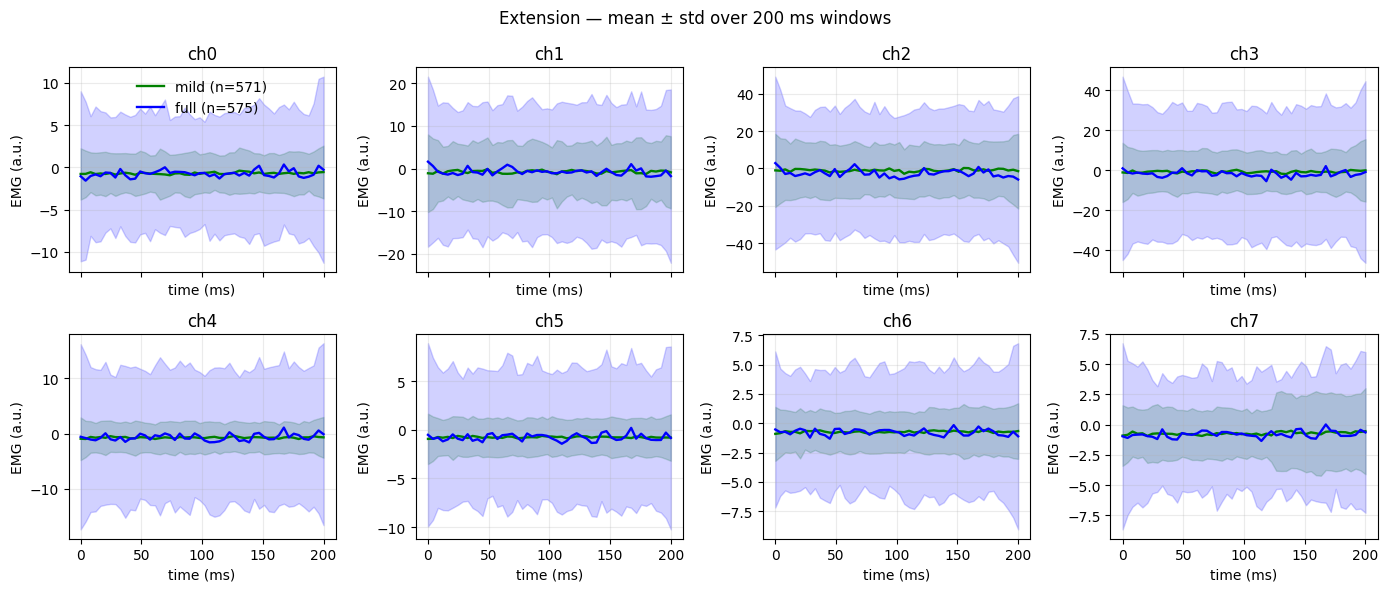

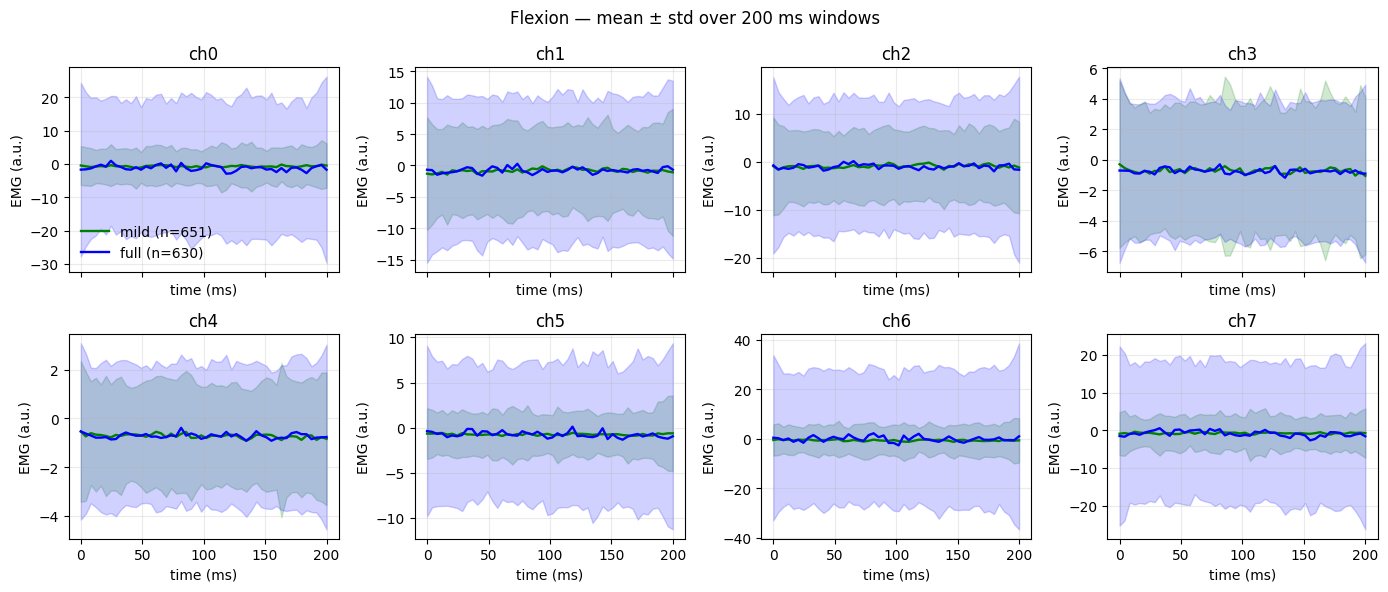

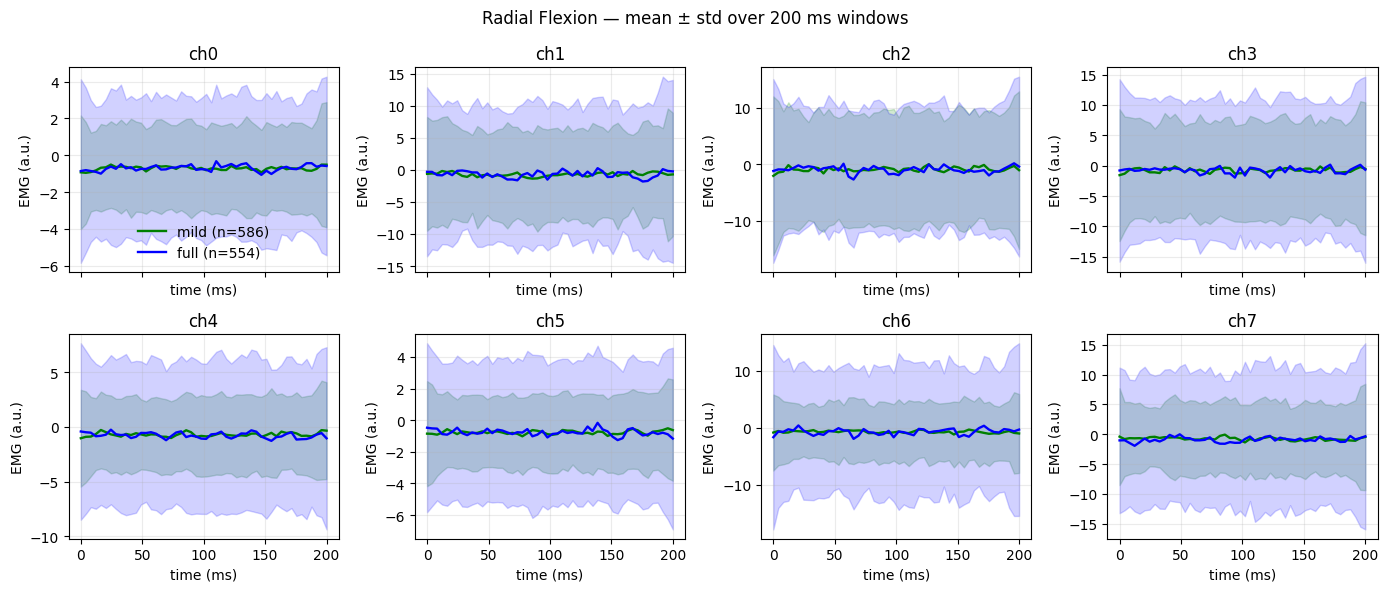

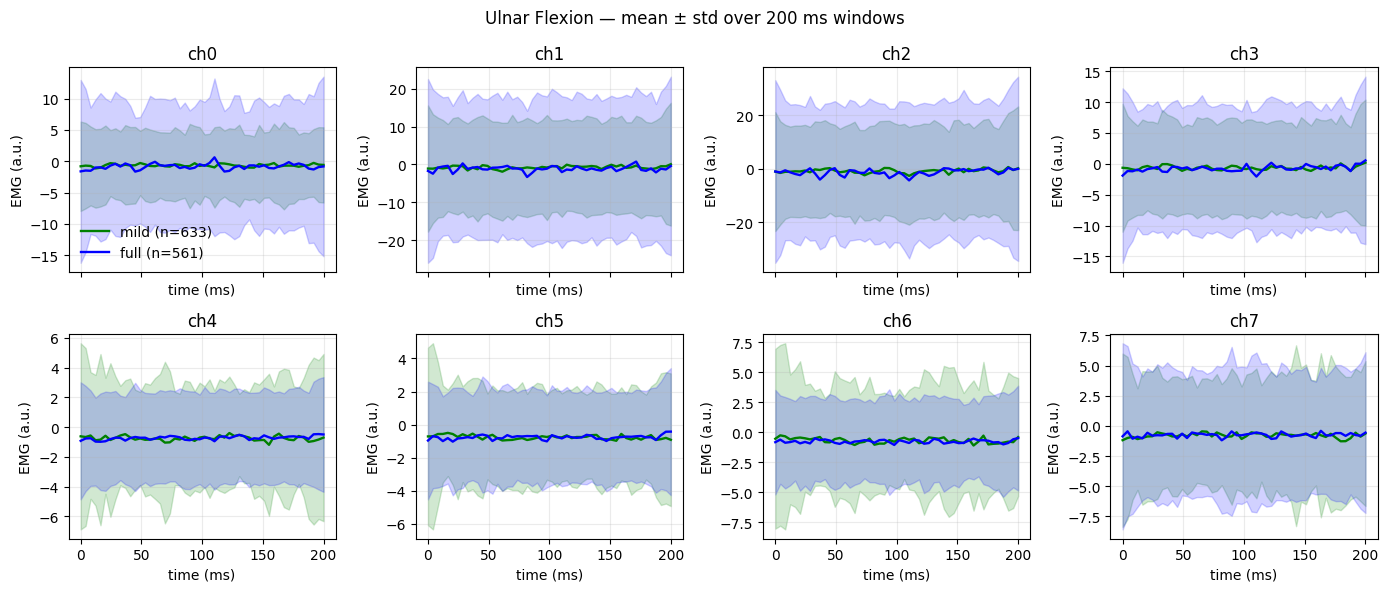

In [2]:
# JUPYTER CELL — Overlay rest (red), mild (green), full (blue) per family across ALL participants/sessions

import os, csv
import numpy as np
import matplotlib.pyplot as plt

SESSIONS_ROOT = "emg_sessions"
WINDOW_MS   = 200
GRID_POINTS = 50

LABELS = {
    0: "rest",
    1: "mild_extension",
    2: "full_extension",
    3: "mild_flexion",
    4: "full_flexion",
    5: "mild_radial_flexion",
    6: "full_radial_flexion",
    7: "mild_ulnar_flexion",
    8: "full_ulnar_flexion",
}

# ---------- robust CSV ----------
def load_csv_table(path, delim=';'):
    for enc in ("utf-8", "cp1252", "latin-1"):
        try:
            with open(path, "r", newline="", encoding=enc, errors="strict") as fp:
                r = csv.reader(fp, delimiter=delim)
                header = next(r, None)
                rows = [row for row in r]
            return header, rows
        except UnicodeDecodeError:
            continue
    with open(path, "r", newline="", encoding="utf-8", errors="replace") as fp:
        r = csv.reader(fp, delimiter=delim)
        header = next(r, None)
        rows = [row for row in r]
    return header, rows

# ---------- find ALL sessions for ALL participants ----------
def all_session_dirs(root=SESSIONS_ROOT):
    if not os.path.isdir(root): return []
    out = []
    for participant in sorted(os.listdir(root)):
        pdir = os.path.join(root, participant)
        if not os.path.isdir(pdir): continue
        for sess in sorted(os.listdir(pdir)):
            sdir = os.path.join(pdir, sess)
            if os.path.isdir(sdir) and \
               os.path.isfile(os.path.join(sdir, "samples.csv")) and \
               os.path.isfile(os.path.join(sdir, "events.csv")):
                out.append(sdir)
    return out

# ---------- loading ----------
def load_samples(samples_rows):
    ts_us, lab = [], []
    chs = [[] for _ in range(8)]
    for row in samples_rows:
        try:
            ts_us.append(int(row[0]))
            lab.append(int(row[3]))            # active_label_id
            for k in range(8):
                chs[k].append(float(row[6+k]))
        except Exception:
            pass
    ts_us = np.asarray(ts_us, dtype=np.int64)
    order = np.argsort(ts_us)
    ts_us = ts_us[order]
    lab   = np.asarray(lab, dtype=np.int16)[order]
    ch    = np.vstack([np.asarray(chs[k], dtype=np.float32) for k in range(8)])[:, order]  # 8×N
    return ts_us, lab, ch

# ---------- trials from labels; invalidate with events ----------
def derive_trials_from_labels(ts_us, lab):
    trials = []
    if lab.size == 0: return trials
    in_run = False; cur_label = 0; start_us = None
    for i in range(lab.size):
        if not in_run and lab[i] > 0:
            in_run = True; cur_label = int(lab[i]); start_us = int(ts_us[i])
        elif in_run:
            if lab[i] != cur_label or i == lab.size-1:
                end_idx = i if lab[i] != cur_label else i
                end_us = int(ts_us[end_idx])
                if end_us > start_us:
                    trials.append({"label_id": cur_label, "start_us": start_us, "end_us": end_us, "status": "ok"})
                in_run = False; cur_label = 0; start_us = None
    return trials

def apply_fail_noisy_from_events(trials, events_rows):
    evs = []
    for row in events_rows:
        try:
            evs.append((int(row[0]), row[2]))
        except Exception:
            pass
    evs.sort(key=lambda x: x[0])
    for ts, ev in evs:
        if ev in ("FAILED", "NOISY"):
            for i in range(len(trials)-1, -1, -1):
                if trials[i]["status"] == "ok" and trials[i]["end_us"] <= ts:
                    trials[i]["status"] = "failed" if ev == "FAILED" else "noisy"
                    break
    return trials

# ---------- windowing & interpolation ----------
def windows_from_interval(ts_us, start_us, end_us, win_us):
    t0 = start_us
    while t0 + win_us <= end_us:
        t1 = t0 + win_us
        i0 = np.searchsorted(ts_us, t0, side="left")
        i1 = np.searchsorted(ts_us, t1, side="right")
        if i1 > i0:
            yield i0, i1, t0, t1
        t0 = t1

def resample_window(ts_us, ch_8xN, t0, t1, npts):
    t = ts_us.astype(np.float64)
    m = (t >= t0) & (t <= t1)
    if m.sum() < 2:  # expand slightly if too few samples
        m = (t >= t0 - 1e5) & (t <= t1 + 1e5)
    t_sub = t[m]
    if t_sub.size < 2:
        t_sub = np.array([t0, t1], dtype=np.float64)
        y_sub = ch_8xN[:, :1].repeat(2, axis=1)
    else:
        y_sub = ch_8xN[:, m]
    grid = np.linspace(t0, t1, npts, dtype=np.float64)
    out  = np.empty((8, npts), dtype=np.float32)
    for c in range(8):
        out[c] = np.interp(grid, t_sub, y_sub[c])
    return (grid - t0) / 1e6, out

# ---------- collect windows for ALL sessions into label buckets ----------
sess_dirs = all_session_dirs(SESSIONS_ROOT)
if not sess_dirs:
    raise RuntimeError(f"No sessions found under {SESSIONS_ROOT}/")

# Accumulate windows per label id (0..8) across the entire dataset
win_cache = {k: [] for k in range(9)}
total_windows = 0

for sdir in sess_dirs:
    _, samples_rows = load_csv_table(os.path.join(sdir, "samples.csv"), delim=';')
    _, events_rows  = load_csv_table(os.path.join(sdir, "events.csv"),  delim=';')

    ts, lab, ch = load_samples(samples_rows)
    trials = derive_trials_from_labels(ts, lab)
    trials = apply_fail_noisy_from_events(trials, events_rows)

    for tr in trials:
        if tr["status"] != "ok": 
            continue
        lid = tr["label_id"]
        for i0, i1, t0, t1 in windows_from_interval(ts, tr["start_us"], tr["end_us"], win_us=int(WINDOW_MS*1000)):
            _, W = resample_window(ts[i0:i1], ch[:, i0:i1], t0, t1, GRID_POINTS)
            win_cache[lid].append(W)
            total_windows += 1

print(f"Collected {total_windows} windows ({WINDOW_MS} ms) across {len(sess_dirs)} sessions.")

# ---------- plotting helper ----------
def plot_family(family_name, triplet_ids, colors=('red','green','blue')):
    """
    triplet_ids: (rest_id, mild_id, full_id)
    Plots all 8 channels; overlays mean ± std for each of rest/mild/full.
    """
    ids = triplet_ids
    data = []
    for lab_id in ids:
        w = win_cache.get(lab_id, [])
        if not w:
            data.append(None)
        else:
            stack = np.stack(w, axis=0)    # (nwin, 8, T)
            mean  = stack.mean(axis=0)     # 8×T
            std   = stack.std(axis=0)      # 8×T
            data.append((mean, std, len(w)))

    time_ms = np.linspace(0, WINDOW_MS, GRID_POINTS)
    fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True)
    fig.suptitle(f"{family_name.title()} — mean ± std over {WINDOW_MS} ms windows")

    for ch_idx in range(8):
        ax = axes[ch_idx//4, ch_idx%4]
        for k, item in enumerate(data):
            if item is None:
                continue
            mean, std, n = item
            m, s = mean[ch_idx], std[ch_idx]
            color = colors[k]
            lbl = {0: "rest", 1: "mild", 2: "full"}[k] + (f" (n={n})" if ch_idx==0 else "")
            ax.plot(time_ms, m, color=color, linewidth=1.7, label=lbl)
            ax.fill_between(time_ms, m - s, m + s, color=color, alpha=0.18)
        ax.set_title(f"ch{ch_idx}")
        ax.set_xlabel("time (ms)"); ax.set_ylabel("EMG (a.u.)")
        ax.grid(True, alpha=0.25)
        if ch_idx == 0:
            ax.legend(frameon=False)

    plt.tight_layout()
    plt.show()

# ---- Plot all four families with requested colors ----
labels_needed = {
    "extension": (0, 1, 2),        # rest, mild_extension, full_extension
    "flexion":   (0, 3, 4),
    "radial flexion": (0, 5, 6),
    "ulnar flexion":  (0, 7, 8),
}

plot_family("extension", labels_needed["extension"], colors=('red','green','blue'))
plot_family("flexion",   labels_needed["flexion"],   colors=('red','green','blue'))
plot_family("radial flexion", labels_needed["radial flexion"], colors=('red','green','blue'))
plot_family("ulnar flexion",  labels_needed["ulnar flexion"],  colors=('red','green','blue'))


Aggregated windows: 26798 (200 ms) across 8 sessions.


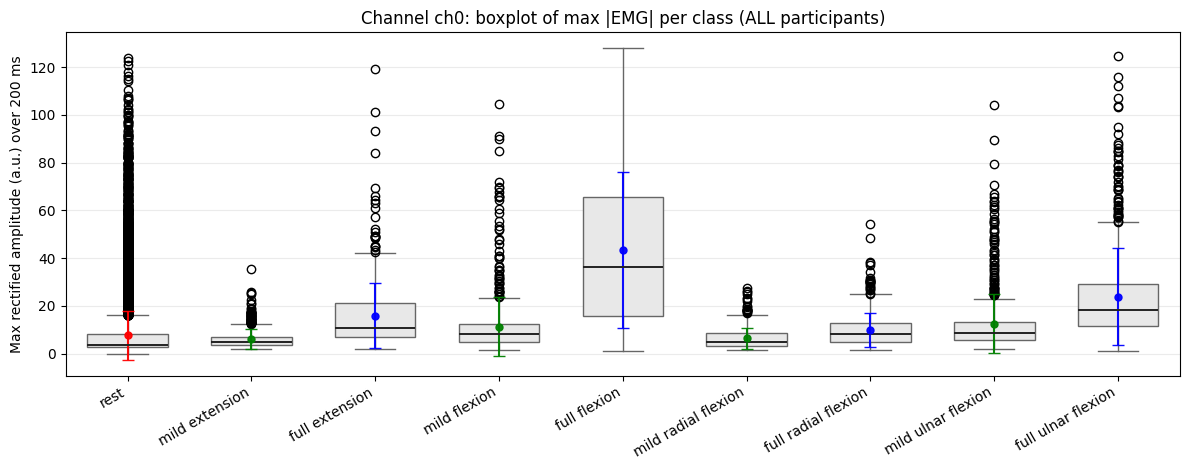

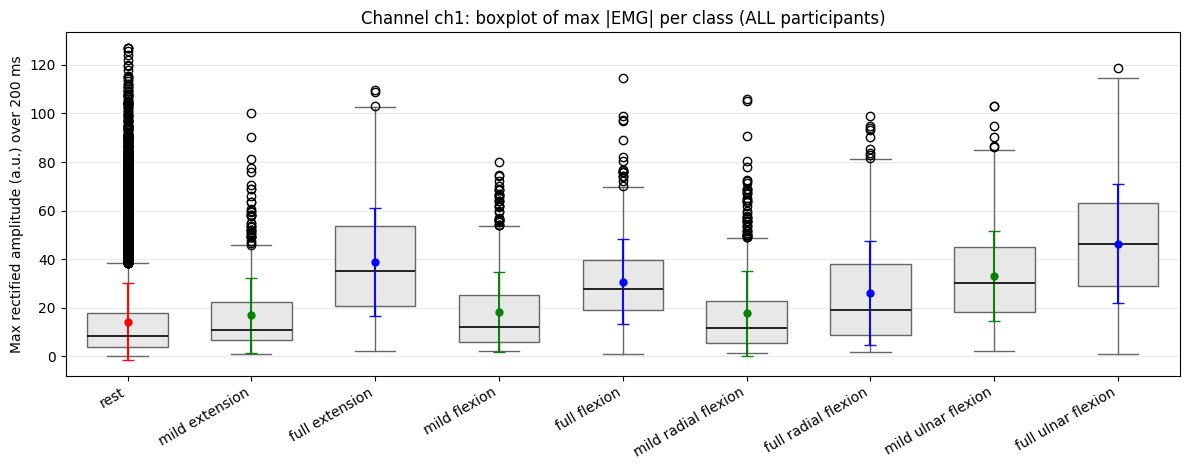

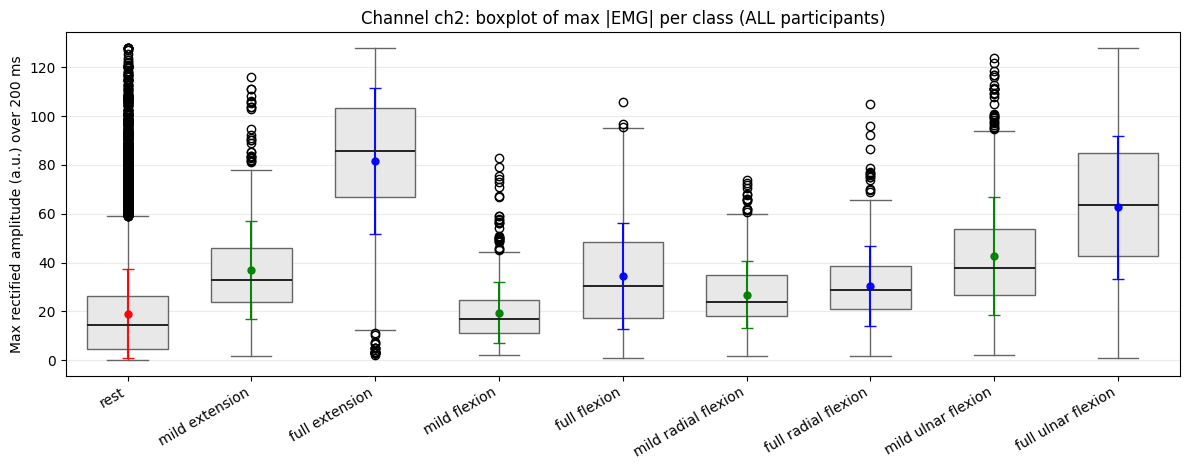

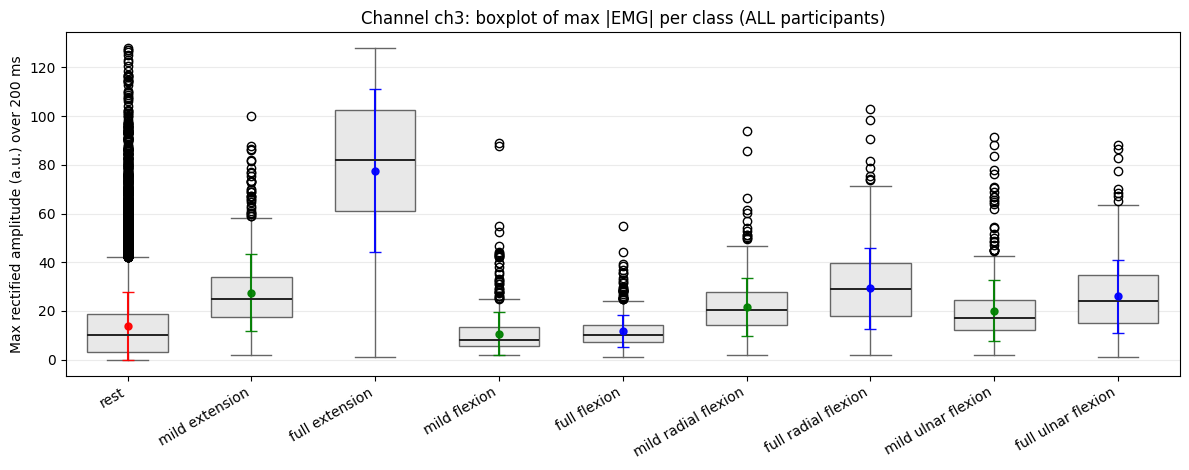

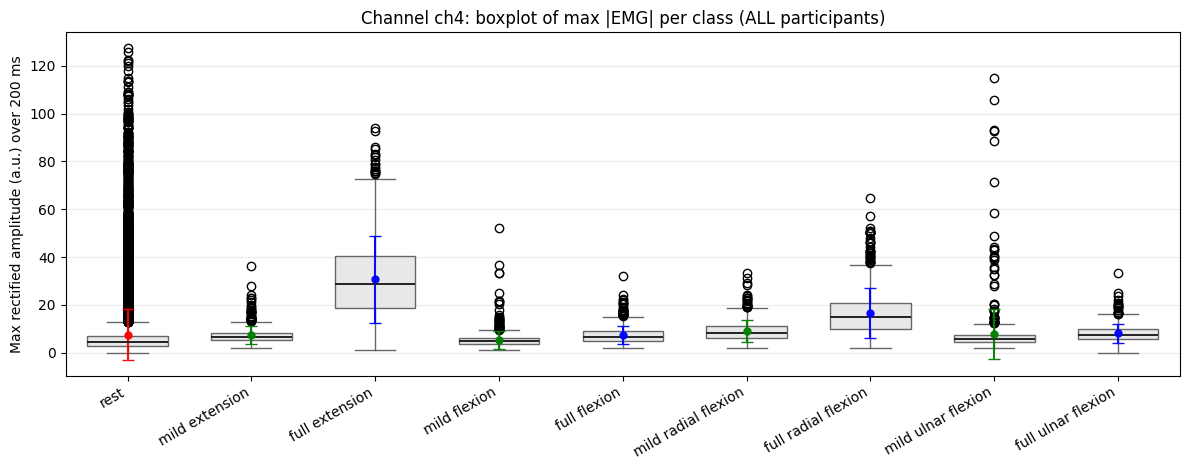

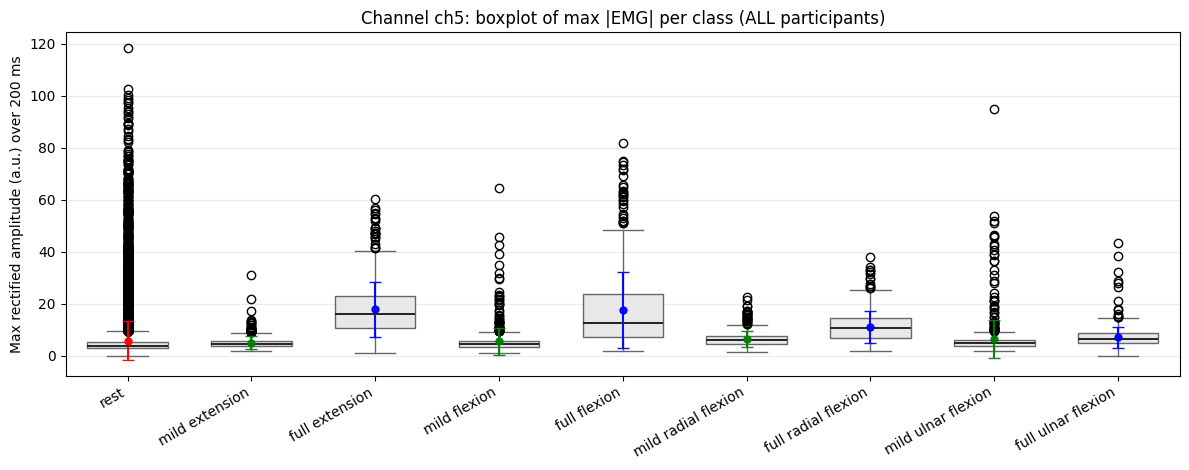

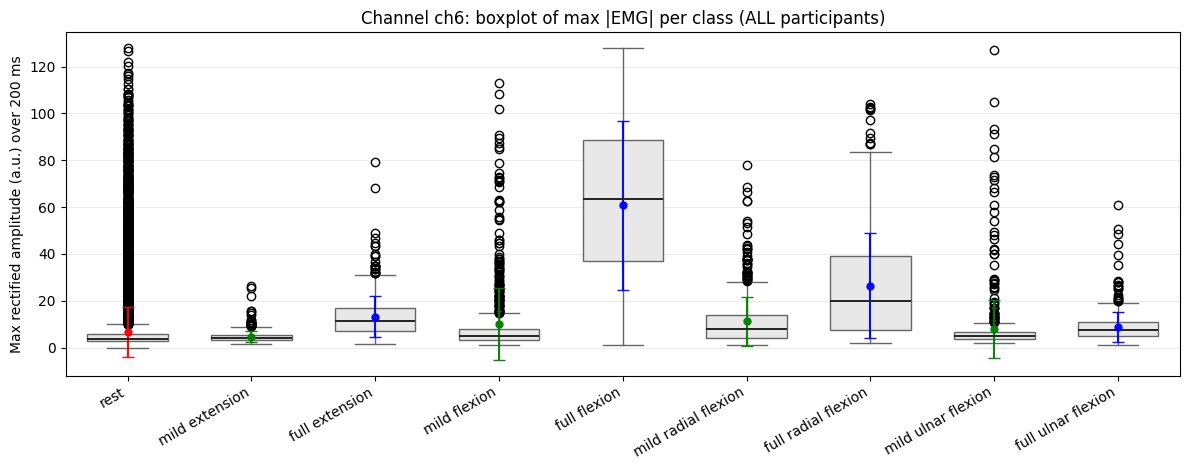

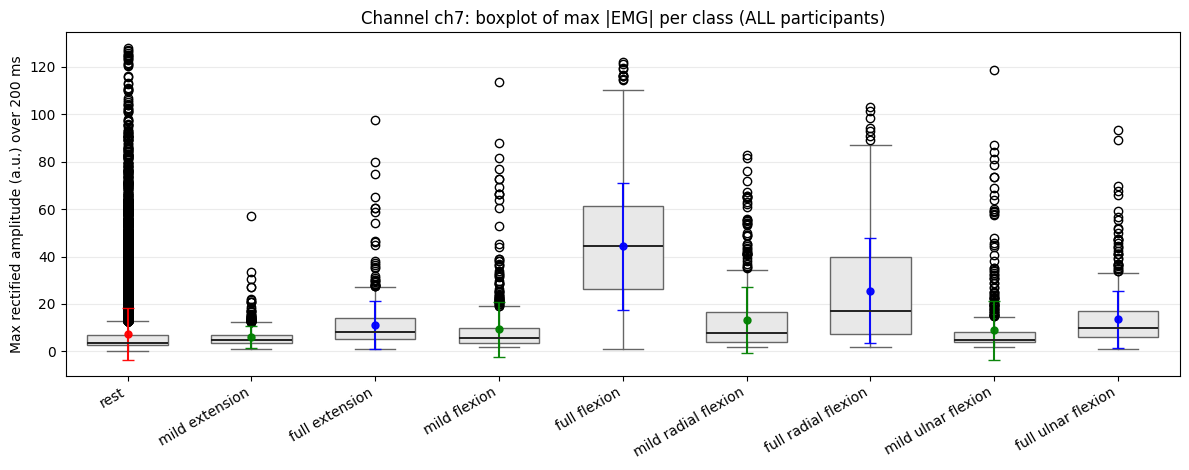

In [3]:
# JUPYTER CELL — Boxplots of max rectified amplitude (200 ms windows) across ALL participants/sessions

import os, csv
import numpy as np
import matplotlib.pyplot as plt

SESSIONS_ROOT = "emg_sessions"
WINDOW_MS     = 200
GRID_POINTS   = 50  # interpolation points per window (handles irregular timing)

LABELS = {
    0: "rest",
    1: "mild_extension",
    2: "full_extension",
    3: "mild_flexion",
    4: "full_flexion",
    5: "mild_radial_flexion",
    6: "full_radial_flexion",
    7: "mild_ulnar_flexion",
    8: "full_ulnar_flexion",
}
label_order = list(range(0, 9))
label_names = [LABELS[k].replace("_", " ") for k in label_order]

# Colors for mean/±std markers (rest=red, mild=green, full=blue; others neutral)
mean_colors = {
    0: "red",  1: "green", 2: "blue",
    3: "green", 4: "blue", 5: "green", 6: "blue", 7: "green", 8: "blue"
}

# ---------- robust CSV ----------
def load_csv_table(path, delim=';'):
    for enc in ("utf-8", "cp1252", "latin-1"):
        try:
            with open(path, "r", newline="", encoding=enc, errors="strict") as fp:
                r = csv.reader(fp, delimiter=delim)
                header = next(r, None)
                rows = [row for row in r]
            return header, rows
        except UnicodeDecodeError:
            continue
    with open(path, "r", newline="", encoding="utf-8", errors="replace") as fp:
        r = csv.reader(fp, delimiter=delim)
        header = next(r, None)
        rows = [row for row in r]
    return header, rows

# ---------- discover ALL sessions (every participant) ----------
def all_session_dirs(root=SESSIONS_ROOT):
    if not os.path.isdir(root): return []
    sessions = []
    for participant in sorted(os.listdir(root)):
        pdir = os.path.join(root, participant)
        if not os.path.isdir(pdir): 
            continue
        for sess in sorted(os.listdir(pdir)):
            sdir = os.path.join(pdir, sess)
            if os.path.isdir(sdir) and \
               os.path.isfile(os.path.join(sdir, "samples.csv")) and \
               os.path.isfile(os.path.join(sdir, "events.csv")):
                sessions.append(sdir)
    return sessions

# ---------- load samples from one session ----------
def load_samples(samples_rows):
    ts_us, lab = [], []
    chs = [[] for _ in range(8)]
    for row in samples_rows:
        try:
            ts_us.append(int(row[0]))         # timestamp_us
            lab.append(int(row[3]))           # active_label_id
            for k in range(8):
                chs[k].append(float(row[6+k]))  # ch0..ch7
        except Exception:
            pass
    ts_us = np.asarray(ts_us, dtype=np.int64)
    order = np.argsort(ts_us)
    ts_us = ts_us[order]
    lab   = np.asarray(lab, dtype=np.int16)[order]
    ch    = np.vstack([np.asarray(chs[k], dtype=np.float32) for k in range(8)])[:, order]  # 8×N
    return ts_us, lab, ch

# ---------- derive trials from labels>0; invalidate with events ----------
def derive_trials_from_labels(ts_us, lab):
    """Contiguous runs with label>0 → trials with status 'ok'."""
    trials = []
    if lab.size == 0: return trials
    in_run = False; cur_label = 0; start_us = None
    for i in range(lab.size):
        if not in_run and lab[i] > 0:
            in_run = True; cur_label = int(lab[i]); start_us = int(ts_us[i])
        elif in_run:
            if lab[i] != cur_label or i == lab.size-1:
                end_idx = i if lab[i] != cur_label else i
                end_us = int(ts_us[end_idx])
                if end_us > start_us:
                    trials.append({"label_id": cur_label, "start_us": start_us, "end_us": end_us, "status": "ok"})
                in_run = False; cur_label = 0; start_us = None
    return trials

def apply_fail_noisy_from_events(trials, events_rows):
    """Mark most recent completed trial as failed/noisy when such marker appears."""
    evs = []
    for row in events_rows:
        try:
            evs.append((int(row[0]), row[2]))  # (timestamp_us, event)
        except Exception:
            pass
    evs.sort(key=lambda x: x[0])
    for ts, ev in evs:
        if ev in ("FAILED", "NOISY"):
            # mark last ok trial that ended before this event
            for i in range(len(trials)-1, -1, -1):
                if trials[i]["status"] == "ok" and trials[i]["end_us"] <= ts:
                    trials[i]["status"] = "failed" if ev == "FAILED" else "noisy"
                    break
    return trials

# ---------- helpers: runs, windows, interpolation ----------
def contiguous_runs(ts_us, labels, target):
    """Yield (start_us, end_us) for contiguous runs where labels==target (duration > 0)."""
    if labels.size == 0: return
    in_run = False; start_us = None
    for i in range(labels.size):
        if not in_run and labels[i] == target:
            in_run = True; start_us = int(ts_us[i])
        elif in_run and (labels[i] != target or i == labels.size-1):
            end_idx = i if labels[i] != target else i
            end_us = int(ts_us[end_idx])
            if end_us > start_us:
                yield start_us, end_us
            in_run = False; start_us = None

def windows_from_interval(ts_us, start_us, end_us, win_us):
    """Yield (i0,i1,t0,t1) for non-overlapping windows of length win_us within [start_us,end_us]."""
    t0 = start_us
    while t0 + win_us <= end_us:
        t1 = t0 + win_us
        i0 = np.searchsorted(ts_us, t0, side="left")
        i1 = np.searchsorted(ts_us, t1, side="right")
        if i1 > i0:
            yield i0, i1, t0, t1
        t0 = t1

def resample_window(ts_us, ch_8xN, t0, t1, npts):
    """Interpolate each channel to a uniform grid in [t0,t1]. Returns (time_rel_s, 8×npts)."""
    t = ts_us.astype(np.float64)
    m = (t >= t0) & (t <= t1)
    if m.sum() < 2:  # expand slightly if too few samples
        m = (t >= t0 - 1e5) & (t <= t1 + 1e5)
    t_sub = t[m]
    if t_sub.size < 2:
        t_sub = np.array([t0, t1], dtype=np.float64)
        y_sub = ch_8xN[:, :1].repeat(2, axis=1)
    else:
        y_sub = ch_8xN[:, m]
    grid = np.linspace(t0, t1, npts, dtype=np.float64)
    out  = np.empty((8, npts), dtype=np.float32)
    for c in range(8):
        out[c] = np.interp(grid, t_sub, y_sub[c])
    return (grid - t0) / 1e6, out

# ---------- compute maxima across ALL sessions ----------
sess_dirs = all_session_dirs(SESSIONS_ROOT)
if not sess_dirs:
    raise RuntimeError(f"No sessions found under {SESSIONS_ROOT}/")

win_us = int(WINDOW_MS * 1000)
# maxima[class_id][channel] = list of floats
maxima = {k: {c: [] for c in range(8)} for k in label_order}
total_windows = 0

for sdir in sess_dirs:
    _, samples_rows = load_csv_table(os.path.join(sdir, "samples.csv"), delim=';')
    _, events_rows  = load_csv_table(os.path.join(sdir, "events.csv"),  delim=';')

    ts_us, lab, ch = load_samples(samples_rows)

    # 1) Movement labels (1..8): use validated trials
    trials = derive_trials_from_labels(ts_us, lab)
    trials = apply_fail_noisy_from_events(trials, events_rows)
    for tr in trials:
        if tr["status"] != "ok":
            continue
        lid = tr["label_id"]
        for i0, i1, t0, t1 in windows_from_interval(ts_us, tr["start_us"], tr["end_us"], win_us):
            _, W = resample_window(ts_us[i0:i1], ch[:, i0:i1], t0, t1, GRID_POINTS)  # 8×GRID_POINTS
            W_rect = np.abs(W)
            w_max = W_rect.max(axis=1)  # (8,)
            for c in range(8):
                maxima[lid][c].append(float(w_max[c]))
            total_windows += 1

    # 2) Rest label (0): take contiguous label==0 runs (rest is not invalidated by FAILED/NOISY)
    for s_us, e_us in contiguous_runs(ts_us, lab, target=0):
        for i0, i1, t0, t1 in windows_from_interval(ts_us, s_us, e_us, win_us):
            _, W = resample_window(ts_us[i0:i1], ch[:, i0:i1], t0, t1, GRID_POINTS)
            W_rect = np.abs(W)
            w_max = W_rect.max(axis=1)
            for c in range(8):
                maxima[0][c].append(float(w_max[c]))
            total_windows += 1

print(f"Aggregated windows: {total_windows} (200 ms) across {len(sess_dirs)} sessions.")

# ---------- plotting: one figure per channel, box per class (+ mean ± std overlay) ----------
for c in range(8):
    fig, ax = plt.subplots(figsize=(12, 4.8))
    data = [maxima[k][c] for k in label_order]

    # Basic boxplot
    bp = ax.boxplot(
        data,
        positions=np.arange(1, len(label_order)+1),
        widths=0.65,
        patch_artist=True,
        showfliers=True
    )

    # Style boxes
    for box in bp['boxes']:
        box.set(facecolor="#e8e8e8", edgecolor="#666666")
    for whisk in bp['whiskers']: whisk.set(color="#666666")
    for cap in bp['caps']:       cap.set(color="#666666")
    for med in bp['medians']:    med.set(color="#222222", linewidth=1.4)

    # Overlay mean ± std
    xs = np.arange(1, len(label_order)+1)
    means = [np.mean(d) if len(d)>0 else np.nan for d in data]
    stds  = [np.std(d)  if len(d)>0 else np.nan for d in data]
    colors = [mean_colors.get(k, "#555555") for k in label_order]
    for x, m, s, col in zip(xs, means, stds, colors):
        if np.isfinite(m):
            ax.errorbar(x, m, yerr=s, fmt='o', color=col, ecolor=col,
                        elinewidth=1.5, capsize=4, markersize=5, alpha=0.95)

    ax.set_xticks(xs)
    ax.set_xticklabels(label_names, rotation=30, ha='right')
    ax.set_ylabel("Max rectified amplitude (a.u.) over 200 ms")
    ax.set_title(f"Channel ch{c}: boxplot of max |EMG| per class (ALL participants)")
    ax.grid(axis='y', alpha=0.25)
    plt.tight_layout()
    plt.show()


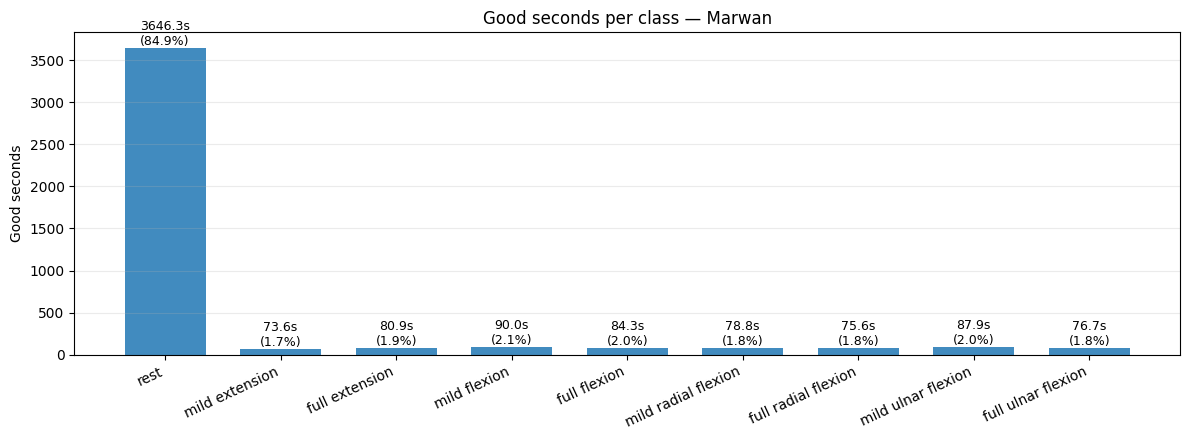

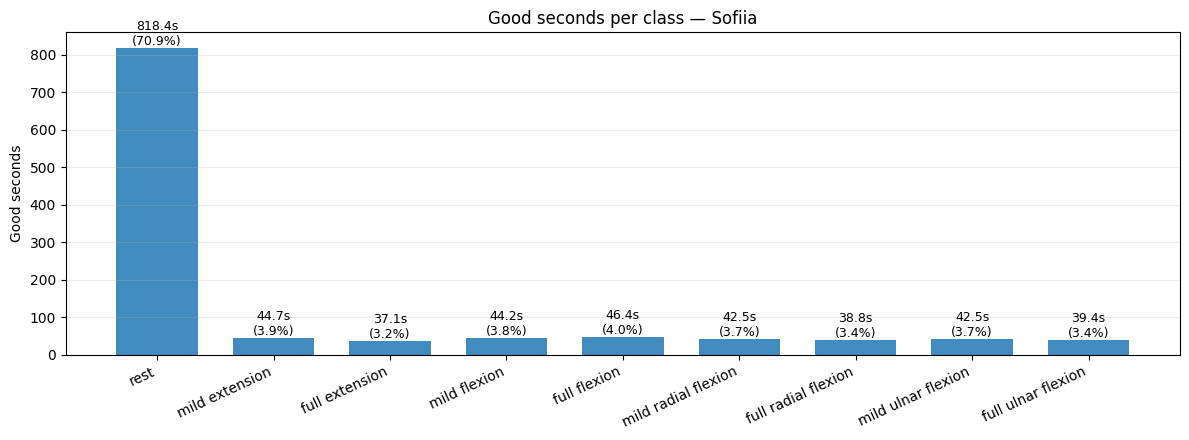

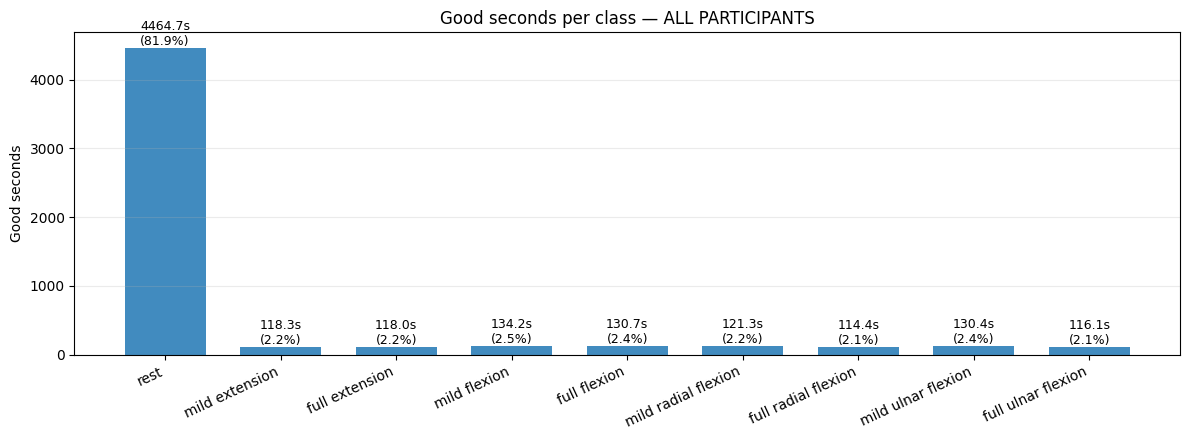

In [4]:
# JUPYTER CELL — "Good seconds" per class: histograms per participant + overall
# Good = time inside trials with label>0 whose trial wasn't later marked FAILED/NOISY.
# Optionally include rest (label 0) from contiguous runs where label==0.

import os, csv
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict

SESSIONS_ROOT = "emg_sessions"
INCLUDE_REST  = True   # set False to hide label 0 from histograms

LABELS = OrderedDict([
    (0, "rest"),
    (1, "mild_extension"),
    (2, "full_extension"),
    (3, "mild_flexion"),
    (4, "full_flexion"),
    (5, "mild_radial_flexion"),
    (6, "full_radial_flexion"),
    (7, "mild_ulnar_flexion"),
    (8, "full_ulnar_flexion"),
])
CLASS_ORDER = list(LABELS.keys()) if INCLUDE_REST else list(range(1,9))

# ---------- robust CSV ----------
def load_csv_table(path, delim=';'):
    for enc in ("utf-8", "cp1252", "latin-1"):
        try:
            with open(path, "r", newline="", encoding=enc, errors="strict") as fp:
                r = csv.reader(fp, delimiter=delim)
                header = next(r, None)
                rows = [row for row in r]
            return header, rows
        except UnicodeDecodeError:
            continue
    with open(path, "r", newline="", encoding="utf-8", errors="replace") as fp:
        r = csv.reader(fp, delimiter=delim)
        header = next(r, None)
        rows = [row for row in r]
    return header, rows

# ---------- discover participants & sessions ----------
def all_participants(root=SESSIONS_ROOT):
    if not os.path.isdir(root): return []
    return sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])

def sessions_for_participant(participant, root=SESSIONS_ROOT):
    pdir = os.path.join(root, participant)
    if not os.path.isdir(pdir): return []
    out = []
    for sess in sorted(os.listdir(pdir)):
        sdir = os.path.join(pdir, sess)
        if os.path.isdir(sdir) and \
           os.path.isfile(os.path.join(sdir, "samples.csv")) and \
           os.path.isfile(os.path.join(sdir, "events.csv")):
            out.append(sdir)
    return out

# ---------- data loading ----------
def load_samples(samples_rows):
    ts_us, lab = [], []
    for row in samples_rows:
        try:
            ts_us.append(int(row[0]))  # timestamp_us
            lab.append(int(row[3]))    # active_label_id
        except Exception:
            pass
    ts_us = np.asarray(ts_us, dtype=np.int64)
    order = np.argsort(ts_us)
    return ts_us[order], np.asarray(lab, dtype=np.int16)[order]

def contiguous_runs(ts_us, labels, target):
    """Yield (start_us, end_us) for contiguous runs where labels==target."""
    if labels.size == 0: return
    in_run = False; start_us = None
    for i in range(labels.size):
        if not in_run and labels[i] == target:
            in_run = True; start_us = int(ts_us[i])
        elif in_run and (labels[i] != target or i == labels.size-1):
            end_idx = i if labels[i] != target else i
            end_us = int(ts_us[end_idx])
            if end_us > start_us:
                yield start_us, end_us
            in_run = False; start_us = None

def derive_movement_trials(ts_us, labels):
    """Trials are contiguous runs where label>0. Returns list of dicts."""
    trials = []
    if labels.size == 0: return trials
    in_run = False; cur_label = 0; start_us = None
    for i in range(labels.size):
        if not in_run and labels[i] > 0:
            in_run = True
            cur_label = int(labels[i])
            start_us  = int(ts_us[i])
        elif in_run:
            if labels[i] != cur_label or i == labels.size-1:
                end_idx = i if labels[i] != cur_label else i
                end_us  = int(ts_us[end_idx])
                if end_us > start_us:
                    trials.append({"label_id": cur_label, "start_us": start_us, "end_us": end_us, "status": "ok"})
                in_run = False; cur_label = 0; start_us = None
    return trials

def apply_fail_noisy_from_events(trials, events_rows):
    """Mark most recent completed trial as failed/noisy based on events."""
    evs = []
    for row in events_rows:
        try:
            evs.append((int(row[0]), row[2]))  # (timestamp_us, event)
        except Exception:
            pass
    evs.sort(key=lambda x: x[0])
    for ts, ev in evs:
        if ev in ("FAILED", "NOISY"):
            for i in range(len(trials)-1, -1, -1):
                if trials[i]["status"] == "ok" and trials[i]["end_us"] <= ts:
                    trials[i]["status"] = "failed" if ev == "FAILED" else "noisy"
                    break
    return trials

# ---------- aggregate good seconds ----------
per_participant_secs = {}   # {participant: {label_id: seconds}}
overall_secs = {k: 0.0 for k in CLASS_ORDER}

participants = all_participants(SESSIONS_ROOT)
if not participants:
    raise RuntimeError(f"No participants found under {SESSIONS_ROOT}/")

for participant in participants:
    label_secs = {k: 0.0 for k in CLASS_ORDER}
    for sdir in sessions_for_participant(participant, SESSIONS_ROOT):
        # load CSVs
        _, samples_rows = load_csv_table(os.path.join(sdir, "samples.csv"), delim=';')
        _, events_rows  = load_csv_table(os.path.join(sdir, "events.csv"),  delim=';')

        ts_us, lab = load_samples(samples_rows)

        # movement trials (1..8)
        trials = derive_movement_trials(ts_us, lab)
        trials = apply_fail_noisy_from_events(trials, events_rows)
        for tr in trials:
            if tr["status"] != "ok":
                continue
            lid = tr["label_id"]
            if lid in label_secs:
                label_secs[lid] += (tr["end_us"] - tr["start_us"]) / 1e6

        # rest (0) if included
        if INCLUDE_REST and 0 in label_secs:
            for s_us, e_us in contiguous_runs(ts_us, lab, target=0):
                label_secs[0] += (e_us - s_us) / 1e6

    # store participant totals
    per_participant_secs[participant] = label_secs
    # add to overall
    for k in CLASS_ORDER:
        overall_secs[k] += label_secs.get(k, 0.0)

# ---------- plotting: histogram per participant + overall ----------
def plot_hist_for(name, label_secs_dict):
    # values & percents
    xs = np.arange(len(CLASS_ORDER))
    vals = np.array([label_secs_dict.get(k, 0.0) for k in CLASS_ORDER], dtype=float)
    total = vals.sum()
    pct  = np.zeros_like(vals) if total <= 0 else (vals / total) * 100.0

    fig, ax1 = plt.subplots(figsize=(12, 4.5))
    bars = ax1.bar(xs, vals, width=0.7, alpha=0.85)
    ax1.set_xticks(xs)
    ax1.set_xticklabels([LABELS[k].replace("_"," ") for k in CLASS_ORDER], rotation=25, ha='right')
    ax1.set_ylabel("Good seconds")
    ax1.set_title(f"Good seconds per class — {name}")

    # annotate with secs & percent
    for x, b, v, p in zip(xs, bars, vals, pct):
        if v > 0:
            ax1.text(b.get_x() + b.get_width()/2, b.get_height(),
                     f"{v:.1f}s\n({p:.1f}%)",
                     ha='center', va='bottom', fontsize=9)

    ax1.grid(axis='y', alpha=0.25)
    plt.tight_layout()
    plt.show()

# one histogram per participant
for participant in sorted(per_participant_secs.keys()):
    plot_hist_for(participant, per_participant_secs[participant])

# final histogram across ALL participants
plot_hist_for("ALL PARTICIPANTS", overall_secs)


In [7]:
# JUPYTER CELL — Build Marwan EMG dataset → windows + preprocessing + cleanup (REST)
# Requires: numpy, pandas, scipy (for filters), tqdm (optional)
import os, glob, json, math, warnings
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime

# -------- Parameters you may tweak --------
SESSIONS_ROOT = "emg_sessions/Marwan"
OUT_DIR       = "emg_datasets"
FS            = 200                 # Hz (Myo stream)
WIN_MS        = 200                 # window length for ML (ms)
HOP_MS        = 30                  # hop length (ms) — training-time default
MARGIN_MS     = 250                 # trim around MOVE_START/END to avoid transitions
ENV_MS        = 50                  # RMS envelope window (ms)
BP_LO_HZ      = 20                  # band-pass low cutoff
BP_HI_HZ      = 90                  # band-pass high cutoff
USE_NOTCH     = True                # 50 Hz notch
NOTCH_Q       = 30

# REST noise filter thresholds
REST_RMS_MULT = 1.5                 # amplitude filter: window RMS < 1.5 × median(rest RMS)
REST_SPECTRAL_RATIO_MIN = 3.0       # spectral: power(20–90)/power(1–15) >= this

LABELS = {
    0: "rest",
    1: "mild_extension",
    2: "full_extension",
    3: "mild_flexion",
    4: "full_flexion",
    5: "mild_radial_flexion",
    6: "full_radial_flexion",
    7: "mild_ulnar_flexion",
    8: "full_ulnar_flexion",
}

# -------- Helpers --------
def hz_to_bins(freqs, fs, n):
    """Return boolean masks for frequency bands on rfft bins."""
    f = np.fft.rfftfreq(n, 1.0/fs)
    def band(lo, hi):
        return (f >= lo) & (f < hi)
    return f, band

def butter_bandpass(bplo, bphi, fs, order=4):
    from scipy.signal import butter
    return butter(order, [bplo/(fs/2.0), bphi/(fs/2.0)], btype='band')

def iir_notch_50(fs, q=30):
    from scipy.signal import iirnotch
    return iirnotch(50.0, q, fs)

def lfilter_zi(b, a, x):
    from scipy.signal import lfilter, lfilter_zi
    zi = lfilter_zi(b, a) * x[:, :1]
    y, zf = lfilter(b, a, x, axis=1, zi=zi)
    return y

def moving_rms(x, win_samp):
    # x: (C, T) non-negative after rectification; returns (C, T)
    if win_samp <= 1:
        return np.sqrt(x)
    # efficient cumulative moving average of squares
    pad = win_samp - 1
    x2 = x**2
    csum = np.cumsum(np.pad(x2, ((0,0),(pad,0))), axis=1)
    # window sums
    wsum = csum[:, win_samp:] - csum[:, :-win_samp]
    # pad left to original length
    left = np.repeat(wsum[:, :1], pad, axis=1)
    rms = np.sqrt(np.concatenate([left, wsum], axis=1) / float(win_samp))
    return rms

def compute_baseline_rms(rest_segments, env_win):
    """
    rest_segments: list of (C,T) arrays (preprocessed up to rectification, before RMS),
    returns per-channel baseline RMS after envelope → scalar per channel
    """
    if not rest_segments:
        return np.ones(8, dtype=np.float32)
    env_all = []
    for seg in rest_segments:
        env = moving_rms(np.abs(seg), env_win)
        env_all.append(env)
    big = np.concatenate(env_all, axis=1)  # (C, total_T)
    # robust baseline as median across time
    base = np.median(big, axis=1)
    base[base == 0] = 1.0
    return base.astype(np.float32)

def preprocess_window(raw_win, fs, b_bp=None, a_bp=None, b_notch=None, a_notch=None, env_win=10, baseline=None):
    """
    raw_win: (C,T) float array
    returns: (C,T) normalized envelope window
    """
    x = raw_win - raw_win.mean(axis=1, keepdims=True)  # DC
    if b_bp is not None:
        x = lfilter_zi(b_bp, a_bp, x)
    if b_notch is not None:
        x = lfilter_zi(b_notch, a_notch, x)
    x = np.abs(x)
    env = moving_rms(x, env_win)
    if baseline is not None:
        env = env / (baseline[:, None] + 1e-6)
    return env.astype(np.float32)

def window_iter(times_s, data, start_s, end_s, win_samp, hop_samp):
    """
    Iterate over windows fully contained in [start_s, end_s].
    times_s: (N,) seconds aligned to rows of data
    data: (N, 8) int/float
    yields (start_idx, end_idx, CxT)
    """
    fs = FS
    # mask rows by time range
    m = (times_s >= start_s) & (times_s <= end_s)
    if not m.any():
        return
    idx = np.where(m)[0]
    i0, i1 = idx[0], idx[-1]
    # Build rolling windows by sample indices
    cdata = data[i0:i1+1]  # (M,8)
    # transpose to (C,T) when slicing each window
    for s0 in range(0, len(cdata) - win_samp + 1, hop_samp):
        s1 = s0 + win_samp
        yield i0 + s0, i0 + s1, cdata[s0:s1].T  # (8, win_samp)

def spectral_ratio(window, fs):
    # window: (C,T) after any preprocessing step you wish to measure; here we use rectified raw
    X = np.abs(np.fft.rfft(window, axis=1))
    f, band = hz_to_bins(None, fs, window.shape[1])
    low = np.sum(X[:, (np.fft.rfftfreq(window.shape[1], 1/fs) < 15)], axis=1)
    mid = np.sum(X[:, (np.fft.rfftfreq(window.shape[1], 1/fs) >= 20) & (np.fft.rfftfreq(window.shape[1], 1/fs) < 90)], axis=1)
    ratio = np.mean((mid + 1e-9) / (low + 1e-9))
    return ratio

# -------- Load & build intervals from events --------
def parse_intervals(events_df, margin_s):
    """
    From events.csv (semicolon; columns: timestamp_us, participant, event, detail)
    -> list of (label_id, start_s, end_s) for DO-only intervals with margin trimmed.
    """
    if events_df is None or events_df.empty:
        return []

    # Build timeline dict per MOVE_START → MOVE_END
    # detail is LABELS[name]; we need label_id by reverse-lookup
    name_to_id = {v: k for k, v in LABELS.items()}
    ev = events_df.copy()
    ev["t_s"] = ev["timestamp_us"].astype(np.int64) / 1e6

    intervals = []
    stack = []
    for _, row in ev.iterrows():
        evt = str(row["event"])
        t = float(row["t_s"])
        detail = str(row.get("detail", "")).strip().lower().replace(" ", "_")
        if evt == "MOVE_START":
            lid = name_to_id.get(detail, None)
            if lid is not None:
                stack.append((lid, t))
        elif evt == "MOVE_END":
            # pop last start
            if stack:
                lid, t0 = stack.pop()
                # trim margins
                start_s = t0 + margin_s
                end_s   = t - margin_s
                if end_s > start_s:
                    intervals.append((lid, start_s, end_s))
        elif evt in ("MOVE_ABORT", "AUTOPAUSE_NO_DATA"):
            # drop any open trial
            stack = []
    return intervals

from io import StringIO

def read_csv_smart(path, sep=';', **kwargs):
    """
    Robust CSV reader:
    - tries utf-8 / utf-8-sig / cp1252 / latin1
    - falls back to utf-8 with 'replace' on decode
    """
    encodings = ['utf-8', 'utf-8-sig', 'cp1252', 'latin1']
    for enc in encodings:
        try:
            return pd.read_csv(path, sep=sep, encoding=enc, engine='python',
                               on_bad_lines='skip', **kwargs)
        except UnicodeDecodeError:
            continue
    # Last resort: manual decode with replacement to avoid crash
    with open(path, 'rb') as f:
        text = f.read().decode('utf-8', errors='replace')
    return pd.read_csv(StringIO(text), sep=sep, engine='python',
                       on_bad_lines='skip', **kwargs)


# --- PATCH: use sample-based intervals instead of events-based (fixes clock mismatch) ---

def contiguous_blocks(mask):
    """Yield (start_idx, end_idx) inclusive for contiguous True blocks in a boolean array."""
    idx = np.where(mask)[0]
    if idx.size == 0:
        return
    start = idx[0]
    prev = idx[0]
    for i in idx[1:]:
        if i != prev + 1:
            yield start, prev
            start = i
        prev = i
    yield start, prev

def parse_do_intervals_from_samples(samples_df, fs, margin_ms):
    """
    Build DO intervals from samples.csv only (no events.csv).
    We split by contiguous DO regions and by label_id within those regions.
    Returns a list of (label_id, start_idx, end_idx) in sample indices AFTER trimming margins.
    """
    if samples_df is None or samples_df.empty:
        return []

    # Valid DO samples: state == "DO" and label in 1..8
    s = samples_df
    is_do = (s["state"] == "DO") & (s["active_label_id"].between(1, 8))
    if not is_do.any():
        return []

    intervals = []
    # margin in samples
    m = int(round((margin_ms / 1000.0) * fs))

    # Walk contiguous DO blocks first
    for b0, b1 in contiguous_blocks(is_do.values):
        # Within a DO block, the label could (rarely) change if operator interrupted; split by label
        labels = s["active_label_id"].values[b0:b1+1]
        # Split whenever label changes
        seg_start = b0
        for i in range(b0+1, b1+1):
            if labels[i-b0] != labels[i-1-b0]:
                seg_end = i-1
                lid = int(s["active_label_id"].values[seg_start])
                # trim margins in samples
                s0 = seg_start + m
                s1 = seg_end   - m
                if s1 - s0 + 1 >= max(1, int(round(FS * WIN_MS / 1000.0))):
                    intervals.append((lid, s0, s1))
                seg_start = i
        # last subsegment
        seg_end = b1
        lid = int(s["active_label_id"].values[seg_start])
        s0 = seg_start + m
        s1 = seg_end   - m
        if s1 - s0 + 1 >= max(1, int(round(FS * WIN_MS / 1000.0))):
            intervals.append((lid, s0, s1))

    return intervals

def window_iter_idx(data, start_idx, end_idx, win_samp, hop_samp):
    """
    Iterate windows fully within [start_idx, end_idx] (inclusive), using sample indices.
    data: (N, 8) array
    yields (i0, i1, (8, T))
    """
    # Ensure inclusive range
    last_start = end_idx - win_samp + 1
    for i0 in range(start_idx, last_start + 1, hop_samp):
        i1 = i0 + win_samp
        yield i0, i1, data[i0:i1].T

# --- Replace the DO interval logic in build_dataset() with this version ---

def build_dataset():
    sessions = sorted(glob.glob(os.path.join(SESSIONS_ROOT, "*")))
    if not sessions:
        raise RuntimeError(f"No sessions found under {SESSIONS_ROOT}")

    win_samp = int(round(FS * WIN_MS / 1000.0))
    hop_samp = int(round(FS * HOP_MS / 1000.0))
    env_win  = int(max(1, round(FS * ENV_MS / 1000.0)))

    # Filters
    b_bp = a_bp = b_notch = a_notch = None
    try:
        b_bp, a_bp = butter_bandpass(BP_LO_HZ, BP_HI_HZ, FS, order=4)
        if USE_NOTCH:
            b_notch, a_notch = iir_notch_50(FS, NOTCH_Q)
    except Exception as e:
        warnings.warn(f"Filter design failed ({e}). Proceeding without filters.")
        b_bp = a_bp = b_notch = a_notch = None

    X_list, y_list, meta_list = [], [], []
    class_counts = {k:0 for k in LABELS.keys()}
    total_kept = 0

    print(f"[INFO] Searching sessions under: {SESSIONS_ROOT}")
    for sess in sessions:
        samples_p = os.path.join(sess, "samples.csv")
        events_p  = os.path.join(sess, "events.csv")
        if not os.path.exists(samples_p):
            print(f"[WARN] Missing samples.csv in {sess}, skipping.")
            continue

        # robust readers you added earlier
        samples = read_csv_smart(samples_p, sep=';')
        # events may be absent/messy; not needed anymore but keep for future
        events  = read_csv_smart(events_p,  sep=';') if os.path.exists(events_p) else None

        # sanity check
        needed = {"timestamp_us","state","active_label_id","active_label_name","stream_index",
                  "ch0","ch1","ch2","ch3","ch4","ch5","ch6","ch7"}
        if not needed.issubset(set(samples.columns)):
            print(f"[WARN] Missing columns in {samples_p}, skipping.")
            continue

        # Raw arrays
        t_us = samples["timestamp_us"].astype(np.int64).values  # not used for indexing anymore
        data = samples[["ch0","ch1","ch2","ch3","ch4","ch5","ch6","ch7"]].astype(np.float32).values

        # REST mask from samples
        rest_mask = (samples["state"] == "REST")

        # ----- Baseline from REST segments (rectified->envelope) -----
        rest_segments = []
        for r0, r1 in contiguous_blocks(rest_mask.values):
            seg = data[r0:r1+1].T
            if seg.shape[1] >= FS * 2:
                rest_segments.append(seg)
        baseline = compute_baseline_rms(rest_segments, env_win) if rest_segments else np.ones(8, dtype=np.float32)

        # ----- DO intervals derived from samples (indices) -----
        do_intervals = parse_do_intervals_from_samples(samples, FS, MARGIN_MS)
        print(f"[{Path(sess).name}] DO intervals: {len(do_intervals)}")

        # Movement windows
        for lid, s0, s1 in do_intervals:
            for i0, i1, raw_win in window_iter_idx(data, s0, s1, win_samp, hop_samp):
                env_win_norm = preprocess_window(raw_win, FS, b_bp, a_bp, b_notch, a_notch, env_win, baseline)
                X_list.append(env_win_norm)
                y_list.append(int(lid))
                meta_list.append((Path(sess).name, int(i0), int(i1)))
                class_counts[lid] += 1
                total_kept += 1

        # ----- REST windows (strictly within REST blocks), with noise rejection -----
        for r0, r1 in contiguous_blocks(rest_mask.values):
            # emit windows strictly inside this block
            for i0, i1, raw_win in window_iter_idx(data, r0, r1, win_samp, hop_samp):
                # preprocess
                env_win_norm = preprocess_window(raw_win, FS, b_bp, a_bp, b_notch, a_notch, env_win, baseline)

                # amplitude gate (envelope RMS vs global baseline)
                global_base = float(np.median(baseline))
                w_rms = np.sqrt(np.mean(env_win_norm**2, axis=1))
                if np.any(w_rms > REST_RMS_MULT * global_base):
                    continue

                # spectral gate on rectified raw (before envelope)
                raw_rect = np.abs(raw_win - raw_win.mean(axis=1, keepdims=True))
                ratio = spectral_ratio(raw_rect, FS)
                if ratio < REST_SPECTRAL_RATIO_MIN:
                    continue

                X_list.append(env_win_norm)
                y_list.append(0)
                meta_list.append((Path(sess).name, int(i0), int(i1)))
                class_counts[0] += 1
                total_kept += 1

    if not X_list:
        raise RuntimeError("No windows collected. Check session names, states, or margins.")

    X = np.stack(X_list, axis=0).astype(np.float32)  # (N, 8, T)
    y = np.array(y_list, dtype=np.int64)

    # Save
    Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
    tag = f"marwan_fs{FS}_win{WIN_MS}ms_hop{HOP_MS}ms_env{ENV_MS}ms_bp{BP_LO_HZ}-{BP_HI_HZ}{'_notch' if USE_NOTCH else ''}"
    out_npz = os.path.join(OUT_DIR, f"emg_{tag}.npz")
    meta = {
        "created": datetime.now().isoformat(),
        "sessions_root": SESSIONS_ROOT,
        "fs": FS, "win_ms": WIN_MS, "hop_ms": HOP_MS, "env_ms": ENV_MS,
        "bp": [BP_LO_HZ, BP_HI_HZ], "use_notch": USE_NOTCH, "notch_q": NOTCH_Q,
        "labels": LABELS, "shape": {"N": int(X.shape[0]), "C": int(X.shape[1]), "T": int(X.shape[2])},
        "rest_filters": {"rms_mult": REST_RMS_MULT, "spectral_ratio_min": REST_SPECTRAL_RATIO_MIN},
        "margin_ms": MARGIN_MS,
        "index_space": "sample_indices",  # important: intervals are in indices, not wall-time
    }
    np.savez_compressed(out_npz, X=X, y=y, meta=json.dumps(meta))

    print(f"\nSaved: {out_npz}")
    print(f"X: {X.shape}  y: {y.shape}  (N, C, T)")
    print("Class counts:")
    for k in sorted(class_counts):
        print(f"  {k:>2} {LABELS[k]:<22}: {class_counts[k]}")
    return out_npz, X.shape, class_counts

# Run
_ = build_dataset()



[INFO] Searching sessions under: emg_sessions/Marwan
[20251004_134952] DO intervals: 0
[20251004_141205] DO intervals: 46
[20251004_142357] DO intervals: 34
[20251004_144612] DO intervals: 25
[20251009_153502] DO intervals: 80

Saved: emg_datasets\emg_marwan_fs200_win200ms_hop30ms_env50ms_bp20-90_notch.npz
X: (16851, 8, 48)  y: (16851,)  (N, C, T)
Class counts:
   0 rest                  : 0
   1 mild_extension        : 1819
   2 full_extension        : 2124
   3 mild_flexion          : 2378
   4 full_flexion          : 2186
   5 mild_radial_flexion   : 2064
   6 full_radial_flexion   : 1974
   7 mild_ulnar_flexion    : 2356
   8 full_ulnar_flexion    : 1950


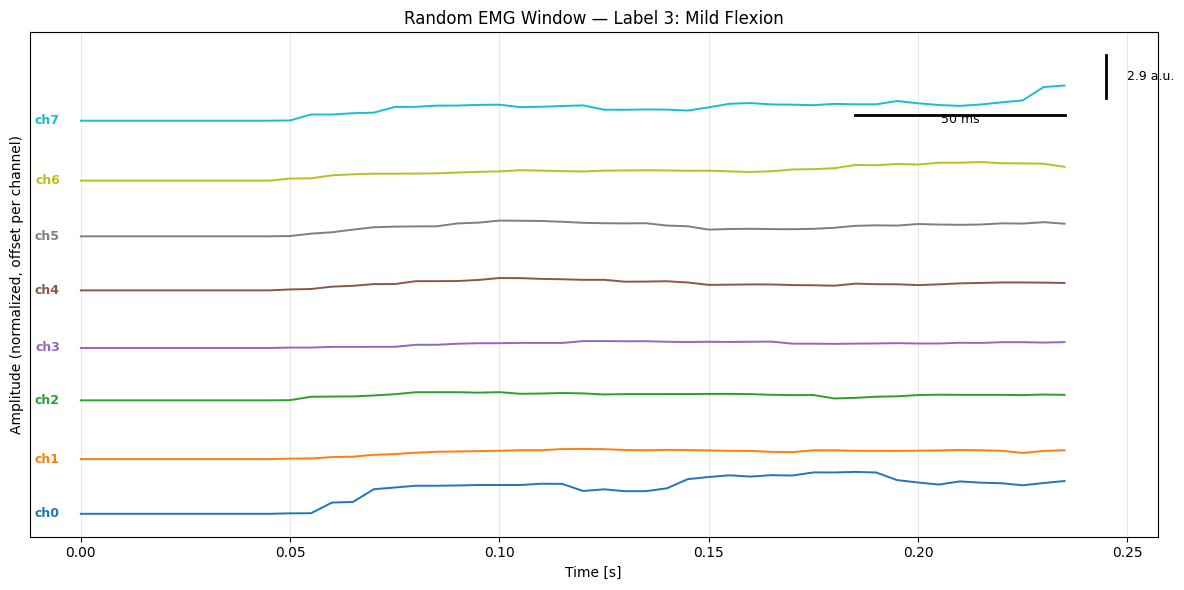

Index: 2226
Label ID: 3
Label Name: mild_flexion
Shape: (8, 48) (C,T) | Duration: 0.20 s


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random

# Path to dataset
DATASET_PATH = "emg_datasets/emg_marwan_fs200_win200ms_hop30ms_env50ms_bp20-90_notch.npz"

# --- Load dataset ---
data = np.load(DATASET_PATH, allow_pickle=True)
X = data["X"]
y = data["y"]
meta = json.loads(data["meta"].item())

LABELS = meta["labels"]
FS = meta["fs"]
WIN_MS = meta["win_ms"]

# --- Pick random sample ---
idx = random.randint(0, len(X)-1)
window = X[idx]
label_id = int(y[idx])
label_name = LABELS[str(label_id)] if isinstance(LABELS, dict) else LABELS[label_id]

# --- Prepare time axis ---
T = window.shape[1]
t = np.arange(T) / FS

# --- Colors and offsets ---
colors = plt.cm.tab10(np.linspace(0, 1, 8))
offset = 1.3 * np.max(np.abs(window))

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 6))
for ch in range(8):
    y_shifted = window[ch] + ch * offset
    ax.plot(t, y_shifted, color=colors[ch], lw=1.4)
    ax.text(-0.005, y_shifted[0], f"ch{ch}", va='center', ha='right',
            fontsize=9, color=colors[ch], weight='bold')

# --- Add amplitude scale (1 unit of offset) ---
scale_amp = offset / 1.3   # ~peak range per channel
scale_t = 0.05             # 50 ms time scale

x_end = t[-1]
y_top = 7.5 * offset

# Draw amplitude scale bar (vertical)
ax.plot([x_end + 0.01, x_end + 0.01],
        [y_top, y_top + scale_amp],
        color='k', lw=2)
ax.text(x_end + 0.015, y_top + scale_amp / 2,
        f"{scale_amp:.1f} a.u.", va='center', fontsize=9)

# Draw time scale bar (horizontal)
ax.plot([x_end - scale_t, x_end],
        [y_top - 0.3 * offset, y_top - 0.3 * offset],
        color='k', lw=2)
ax.text(x_end - scale_t / 2, y_top - 0.45 * offset,
        f"{int(scale_t*1000)} ms", ha='center', fontsize=9)

# --- Aesthetics ---
ax.set_title(f"Random EMG Window — Label {label_id}: {label_name.replace('_',' ').title()}")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude (normalized, offset per channel)")
ax.grid(True, alpha=0.3)
ax.set_yticks([])
plt.tight_layout()
plt.show()

print(f"Index: {idx}")
print(f"Label ID: {label_id}")
print(f"Label Name: {label_name}")
print(f"Shape: {window.shape} (C,T) | Duration: {WIN_MS/1000:.2f} s")
